In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import os
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)
# df_trainval

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds_trainval = pd.read_csv(params.indunsc_trainval_csv, index_col=0, parse_dates=True)
# compute synthetic ask/bid from close_raw and configured spread
df_inds_trainval['ask'] = df_inds_trainval['close'] * (1 + params.bidask_spread_pct/100)
df_inds_trainval['bid'] = df_inds_trainval['close'] * (1 - params.bidask_spread_pct/100)

df_inds_trainval

,open,high,low,close,volume,signal,ret,log_ret,sma_9,sma_21,sma_pct_9,sma_pct_21,ema_9,ema_21,roc_9,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,macd_line,macd_signal,macd_diff,atr_14,atr_pct_14,bb_lband_20,bb_hband_20,bb_w_20,plus_di,minus_di,adx,obv,vwap_14,vwap_dev_pct_14,vol_spike,vol_z_14,rolling_max_close_21,rolling_min_close_21,dist_high_21,dist_low_21,obv_sma,obv_diff_14,obv_pct_14,obv_sma_14,obv_z_14,ret_30,sma_30,sma_pct_30,ema_30,roc_30,rsi_30,atr_30,atr_pct_30,bb_lband_30,bb_hband_30,bb_w_30,plus_di_30,minus_di_30,adx_30,obv_diff_30,obv_pct_30,obv_sma_30,obv_z_30,vwap_30,vwap_dev_pct_30,z_vwap_dev_30,vol_spike_30,vol_z_30,ret_std_30,rolling_max_close_30,rolling_min_close_30,dist_high_30,dist_low_30,macd_line_30,macd_signal_30,macd_diff_30,ret_45,sma_45,sma_pct_45,ema_45,roc_45,rsi_45,atr_45,atr_pct_45,bb_lband_45,bb_hband_45,bb_w_45,plus_di_45,minus_di_45,adx_45,obv_diff_45,obv_pct_45,obv_sma_45,obv_z_45,vwap_45,vwap_dev_pct_45,z_vwap_dev_45,vol_spike_45,vol_z_45,ret_std_45,rolling_max_close_45,rolling_min_close_45,dist_high_45,dist_low_45,macd_line_45,macd_signal_45,macd_diff_45,ret_60,sma_60,sma_pct_60,ema_60,roc_60,rsi_60,atr_60,atr_pct_60,bb_lband_60,bb_hband_60,bb_w_60,plus_di_60,minus_di_60,adx_60,obv_diff_60,obv_pct_60,obv_sma_60,obv_z_60,vwap_60,vwap_dev_pct_60,z_vwap_dev_60,vol_spike_60,vol_z_60,ret_std_60,rolling_max_close_60,rolling_min_close_60,dist_high_60,dist_low_60,macd_line_60,macd_signal_60,macd_diff_60,volume_z_30,vol_spike_z_30,ret_std_z_30,obv_pct_z_30,vwap_dev_pct_z_30,bb_w_z_30,atr_z_30,macd_diff_z_30,volume_z_45,vol_spike_z_45,ret_std_z_45,obv_pct_z_45,vwap_dev_pct_z_45,bb_w_z_45,atr_z_45,macd_diff_z_45,volume_z_60,vol_spike_z_60,ret_std_z_60,obv_pct_z_60,vwap_dev_pct_z_60,bb_w_z_60,atr_z_60,macd_diff_z_60,minute_time,hour_time,dow_time,month_time,day_of_year_time,week_of_year_time,in_sess_time,eng_ma,eng_macd,eng_bb,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,z_eng_atr,eng_sma_short,eng_sma_long,eng_vwap,z_vwap_dev,z_bb_w,z_obv,mom_sum_30,mom_std_30,mom_sum_45,mom_std_45,mom_sum_60,mom_std_60,eng_ema_cross_up,eng_ema_cross_down,ask,bid
2009-01-02 10:58:00,3.069643,3.069643,3.069643,3.069643,13160.0,1.645129e-12,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.0000,0.000000,0.00,0.0000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,1566040.0,3.069643,0.000000,1.000000,0.000000,3.069643,3.069643,0.000000,0.000000,1.480500e+06,184240.0,60020.011635,1.480500e+06,1.553797,0.000000,3.069643,0.000000,3.069643,0.000000,100.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,394800.0,128614.310646,1.375220e+06,0.674491,3.069643,-1.446713e-14,0.000000,1.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.069643,0.000000,3.069643,0.000000,100.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,592200.0,192921.465969,1.276520e+06,0.674491,3.069643,-1.446713e-14,0.000000,1.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.069643,0.000000,3.069643,0.000000,100.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,789600.0,257228.621291,1.177820e+06,0.674491,3.069643,-1.446713e-14,0.000000,1.000000,0.000000,0.000000,3.069643,3.069643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.352778,0.312500,0.071429,0.500000,0.502740,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.30000,0.000000,0.127854,0.000000,0.000000,0.000000,0.000000,-100.000000,0.000000,0.000000,1.388730,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.070257,3.069029
2009-01-02 10:59:00,3.069643,3.069643,3.069643,3.0

In [5]:
df = df_inds_trainval # SELECT THE CORRECT DATAFRAME

baseline_pnl = round((df["bid"].iloc[-1] - df["ask"].iloc[0]) / df.index.normalize().nunique(),4)
baseline_pnl

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 70
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    
    sellmin_idx    = trial.suggest_categorical("sellmin_idx", [None, -1, -2, -3])
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.03, 0.3)
    rsi_thresh     = trial.suggest_float("rsi_thresh", 30, 70)
    atr_mult       = trial.suggest_float("atr_mult", 0, 10)
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -10, 10)
    sess_start     = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))

    print('-' * 150)
    print(f"Params => sellmin_idx={sellmin_idx}, trailstop_pct={trailstop_pct:.4f}, rsi_thresh={rsi_thresh:.2f}, atr_mult={atr_mult:.3f}, vwap_atr_mult={vwap_atr_mult:.3f}, sess_start={sess_start}")
    
    daily_pnls: List[float] = []
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_tradact_ema921(
            df              = df_day,
            col_signal      = "ema_9",
            sign_thresh     = "ema_21",
            col_atr         = "atr_14",
            col_rsi         = "rsi_6",
            col_vwap        = "vwap_14",
            sellmin_idx     = sellmin_idx,
            trailstop_pct   = trailstop_pct,
            rsi_thresh      = rsi_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            sess_start      = sess_start
        )

        sim = strategies.simulate_trading(
            day               = day,
            df                = df_actions,
            sellmin_idx       = sellmin_idx, 
            sess_start        = sess_start
        )
   
        _, _, stats = next(iter(sim.values()))
        
        strategy_val = float(_findall(stats["STRATEGY"])[-1]) 

        daily_pnls.append(strategy_val)

        # Explicitly delete large locals at the end of each trial (no per-iteration gc.collect)
        del df_actions, sim, stats
        df_day = df_actions = sim = stats = None

        # Rreport for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1518, rsi_thresh=55.84, atr_mult=5.249, vwap_atr_mult=1.796, sess_start=14:30:00


Trial 0: 100%|██████████| 3519/3519 [01:30<00:00, 39.06it/s]


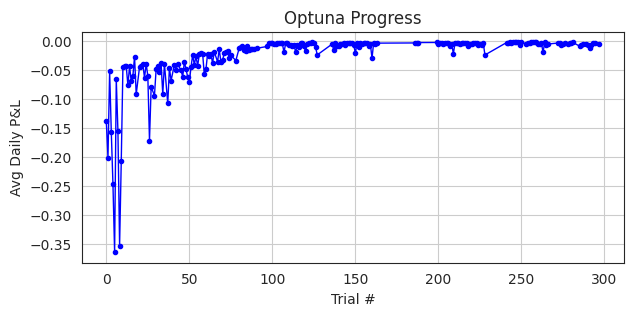

[Results] Trial 0 finished with value: -0.1387. Improvement over baseline: -477.94%.     Best is trial 0 with value: -0.1387.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1173, rsi_thresh=44.76, atr_mult=9.182, vwap_atr_mult=1.739, sess_start=13:30:00


Trial 1: 100%|██████████| 3519/3519 [01:23<00:00, 42.11it/s]


[Results] Trial 1 finished with value: -0.2012. Improvement over baseline: -648.14%.     Best is trial 0 with value: -0.1387.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2557, rsi_thresh=32.21, atr_mult=9.519, vwap_atr_mult=5.186, sess_start=14:30:00


Trial 2: 100%|██████████| 3519/3519 [01:15<00:00, 46.70it/s]


[Results] Trial 2 finished with value: -0.0523. Improvement over baseline: -242.45%.     Best is trial 2 with value: -0.0523.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2762, rsi_thresh=45.28, atr_mult=7.590, vwap_atr_mult=0.763, sess_start=13:30:00


Trial 3: 100%|██████████| 3519/3519 [01:33<00:00, 37.57it/s]


[Results] Trial 3 finished with value: -0.1572. Improvement over baseline: -528.27%.     Best is trial 2 with value: -0.0523.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2296, rsi_thresh=38.05, atr_mult=7.239, vwap_atr_mult=-3.018, sess_start=14:30:00


Trial 4: 100%|██████████| 3519/3519 [01:47<00:00, 32.61it/s]


[Results] Trial 4 finished with value: -0.2476. Improvement over baseline: -774.57%.     Best is trial 2 with value: -0.0523.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1935, rsi_thresh=56.14, atr_mult=1.986, vwap_atr_mult=-9.791, sess_start=13:30:00


Trial 5: 100%|██████████| 3519/3519 [01:36<00:00, 36.42it/s]


[Results] Trial 5 finished with value: -0.3647. Improvement over baseline: -1093.83%.     Best is trial 2 with value: -0.0523.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1117, rsi_thresh=43.52, atr_mult=9.444, vwap_atr_mult=7.715, sess_start=13:30:00


Trial 6: 100%|██████████| 3519/3519 [01:16<00:00, 46.00it/s]


[Results] Trial 6 finished with value: -0.0662. Improvement over baseline: -280.49%.     Best is trial 2 with value: -0.0523.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2159, rsi_thresh=41.00, atr_mult=8.168, vwap_atr_mult=-0.043, sess_start=14:30:00


Trial 7: 100%|██████████| 3519/3519 [01:47<00:00, 32.72it/s]


[Results] Trial 7 finished with value: -0.1556. Improvement over baseline: -523.96%.     Best is trial 2 with value: -0.0523.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1446, rsi_thresh=61.65, atr_mult=0.479, vwap_atr_mult=-3.136, sess_start=13:30:00


Trial 8: 100%|██████████| 3519/3519 [01:29<00:00, 39.46it/s]


[Results] Trial 8 finished with value: -0.3533. Improvement over baseline: -1062.59%.     Best is trial 2 with value: -0.0523.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2479, rsi_thresh=54.44, atr_mult=5.499, vwap_atr_mult=-3.548, sess_start=14:30:00


Trial 9: 100%|██████████| 3519/3519 [01:25<00:00, 40.93it/s]


[Results] Trial 9 finished with value: -0.2080. Improvement over baseline: -666.72%.     Best is trial 2 with value: -0.0523.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0351, rsi_thresh=30.28, atr_mult=3.229, vwap_atr_mult=9.127, sess_start=14:30:00


Trial 10: 100%|██████████| 3519/3519 [01:01<00:00, 57.50it/s]


[Results] Trial 10 finished with value: -0.0446. Improvement over baseline: -221.56%.     Best is trial 10 with value: -0.0446.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0397, rsi_thresh=32.32, atr_mult=2.980, vwap_atr_mult=9.379, sess_start=14:30:00


Trial 11: 100%|██████████| 3519/3519 [01:01<00:00, 56.77it/s]


[Results] Trial 11 finished with value: -0.0434. Improvement over baseline: -218.31%.     Best is trial 11 with value: -0.0434.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0310, rsi_thresh=30.69, atr_mult=3.015, vwap_atr_mult=9.435, sess_start=14:30:00


Trial 12: 100%|██████████| 3519/3519 [01:02<00:00, 56.52it/s]


[Results] Trial 12 finished with value: -0.0434. Improvement over baseline: -218.26%.     Best is trial 12 with value: -0.0434.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0334, rsi_thresh=35.80, atr_mult=3.211, vwap_atr_mult=5.943, sess_start=14:30:00


Trial 13: 100%|██████████| 3519/3519 [01:11<00:00, 49.09it/s]


[Results] Trial 13 finished with value: -0.0765. Improvement over baseline: -308.36%.     Best is trial 12 with value: -0.0434.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0738, rsi_thresh=34.92, atr_mult=3.464, vwap_atr_mult=9.124, sess_start=14:30:00


Trial 14: 100%|██████████| 3519/3519 [01:00<00:00, 58.40it/s]


[Results] Trial 14 finished with value: -0.0433. Improvement over baseline: -217.95%.     Best is trial 14 with value: -0.0433.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0864, rsi_thresh=69.59, atr_mult=1.059, vwap_atr_mult=4.923, sess_start=14:30:00


Trial 15: 100%|██████████| 3519/3519 [01:07<00:00, 51.83it/s]


[Results] Trial 15 finished with value: -0.0698. Improvement over baseline: -290.07%.     Best is trial 14 with value: -0.0433.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.0778, rsi_thresh=36.91, atr_mult=4.409, vwap_atr_mult=7.439, sess_start=14:30:00


Trial 16: 100%|██████████| 3519/3519 [01:13<00:00, 48.17it/s]


[Results] Trial 16 finished with value: -0.0603. Improvement over baseline: -264.29%.     Best is trial 14 with value: -0.0433.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0706, rsi_thresh=48.59, atr_mult=4.273, vwap_atr_mult=9.586, sess_start=14:30:00


Trial 17: 100%|██████████| 3519/3519 [01:04<00:00, 54.86it/s]


[Results] Trial 17 finished with value: -0.0268. Improvement over baseline: -172.94%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0774, rsi_thresh=49.45, atr_mult=6.591, vwap_atr_mult=3.906, sess_start=14:30:00


Trial 18: 100%|██████████| 3519/3519 [01:15<00:00, 46.75it/s]


[Results] Trial 18 finished with value: -0.0918. Improvement over baseline: -350.18%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1848, rsi_thresh=49.20, atr_mult=3.950, vwap_atr_mult=-8.376, sess_start=14:30:00


Trial 19:  25%|██▌       | 895/3519 [00:24<01:12, 36.20it/s]


[PRUNE] value=-0.100743 thr=-0.022293
[Results] Trial 19 finished with value: -0.1007. Improvement over baseline: -374.50%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1173, rsi_thresh=62.74, atr_mult=5.830, vwap_atr_mult=6.885, sess_start=14:30:00


Trial 20: 100%|██████████| 3519/3519 [01:05<00:00, 53.47it/s]


[Results] Trial 20 finished with value: -0.0450. Improvement over baseline: -222.70%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0554, rsi_thresh=35.37, atr_mult=2.107, vwap_atr_mult=9.660, sess_start=14:30:00


Trial 21: 100%|██████████| 3519/3519 [01:01<00:00, 56.89it/s]


[Results] Trial 21 finished with value: -0.0424. Improvement over baseline: -215.60%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0660, rsi_thresh=40.45, atr_mult=1.698, vwap_atr_mult=9.947, sess_start=14:30:00


Trial 22: 100%|██████████| 3519/3519 [01:03<00:00, 54.99it/s]


[Results] Trial 22 finished with value: -0.0398. Improvement over baseline: -208.51%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0650, rsi_thresh=40.41, atr_mult=1.813, vwap_atr_mult=7.258, sess_start=14:30:00


Trial 23: 100%|██████████| 3519/3519 [01:14<00:00, 47.55it/s]


[Results] Trial 23 finished with value: -0.0636. Improvement over baseline: -273.35%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1018, rsi_thresh=46.78, atr_mult=1.976, vwap_atr_mult=9.903, sess_start=14:30:00


Trial 24: 100%|██████████| 3519/3519 [01:07<00:00, 52.15it/s]


[Results] Trial 24 finished with value: -0.0389. Improvement over baseline: -206.07%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0998, rsi_thresh=52.43, atr_mult=0.042, vwap_atr_mult=7.685, sess_start=14:30:00


Trial 25: 100%|██████████| 3519/3519 [01:11<00:00, 49.07it/s]


[Results] Trial 25 finished with value: -0.0602. Improvement over baseline: -264.06%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1334, rsi_thresh=47.44, atr_mult=1.379, vwap_atr_mult=2.840, sess_start=13:30:00


Trial 26: 100%|██████████| 3519/3519 [01:08<00:00, 51.19it/s]


[Results] Trial 26 finished with value: -0.1719. Improvement over baseline: -568.35%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0943, rsi_thresh=41.19, atr_mult=4.497, vwap_atr_mult=5.774, sess_start=14:30:00


Trial 27: 100%|██████████| 3519/3519 [01:05<00:00, 53.51it/s]


[Results] Trial 27 finished with value: -0.0790. Improvement over baseline: -315.28%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0522, rsi_thresh=47.60, atr_mult=2.155, vwap_atr_mult=-5.510, sess_start=14:30:00


Trial 28:  25%|██▌       | 897/3519 [00:24<01:10, 37.02it/s]


[PRUNE] value=-0.132740 thr=-0.015896
[Results] Trial 28 finished with value: -0.1327. Improvement over baseline: -461.69%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1599, rsi_thresh=57.59, atr_mult=0.933, vwap_atr_mult=3.764, sess_start=14:30:00


Trial 29: 100%|██████████| 3519/3519 [01:19<00:00, 44.05it/s]


[Results] Trial 29 finished with value: -0.0942. Improvement over baseline: -356.61%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1336, rsi_thresh=52.62, atr_mult=4.848, vwap_atr_mult=8.235, sess_start=14:30:00


Trial 30: 100%|██████████| 3519/3519 [01:03<00:00, 55.32it/s]


[Results] Trial 30 finished with value: -0.0486. Improvement over baseline: -232.38%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0586, rsi_thresh=39.57, atr_mult=2.180, vwap_atr_mult=9.620, sess_start=14:30:00


Trial 31: 100%|██████████| 3519/3519 [00:59<00:00, 59.03it/s]


[Results] Trial 31 finished with value: -0.0422. Improvement over baseline: -214.95%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0606, rsi_thresh=43.58, atr_mult=2.349, vwap_atr_mult=8.228, sess_start=14:30:00


Trial 32: 100%|██████████| 3519/3519 [01:03<00:00, 55.46it/s]


[Results] Trial 32 finished with value: -0.0536. Improvement over baseline: -246.03%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0983, rsi_thresh=39.38, atr_mult=2.671, vwap_atr_mult=9.930, sess_start=14:30:00


Trial 33: 100%|██████████| 3519/3519 [01:01<00:00, 57.38it/s]


[Results] Trial 33 finished with value: -0.0385. Improvement over baseline: -204.80%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1040, rsi_thresh=45.69, atr_mult=3.879, vwap_atr_mult=6.281, sess_start=13:30:00


Trial 34: 100%|██████████| 3519/3519 [01:03<00:00, 55.21it/s]


[Results] Trial 34 finished with value: -0.0919. Improvement over baseline: -350.29%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1227, rsi_thresh=42.51, atr_mult=1.583, vwap_atr_mult=9.871, sess_start=14:30:00


Trial 35: 100%|██████████| 3519/3519 [00:58<00:00, 59.68it/s]


[Results] Trial 35 finished with value: -0.0391. Improvement over baseline: -206.46%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1270, rsi_thresh=42.57, atr_mult=2.522, vwap_atr_mult=0.093, sess_start=14:30:00


Trial 36:  26%|██▌       | 899/3519 [00:22<01:06, 39.54it/s]


[PRUNE] value=-0.087713 thr=-0.014849
[Results] Trial 36 finished with value: -0.0877. Improvement over baseline: -339.00%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1698, rsi_thresh=46.30, atr_mult=0.852, vwap_atr_mult=4.797, sess_start=13:30:00


Trial 37: 100%|██████████| 3519/3519 [01:12<00:00, 48.75it/s]


[Results] Trial 37 finished with value: -0.1077. Improvement over baseline: -393.44%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1486, rsi_thresh=51.52, atr_mult=3.793, vwap_atr_mult=8.460, sess_start=14:30:00


Trial 38: 100%|██████████| 3519/3519 [01:00<00:00, 58.09it/s]


[Results] Trial 38 finished with value: -0.0463. Improvement over baseline: -226.02%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.0926, rsi_thresh=38.09, atr_mult=2.572, vwap_atr_mult=6.691, sess_start=13:30:00


Trial 39: 100%|██████████| 3519/3519 [01:08<00:00, 51.19it/s]


[Results] Trial 39 finished with value: -0.0682. Improvement over baseline: -285.90%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1127, rsi_thresh=44.27, atr_mult=1.596, vwap_atr_mult=2.320, sess_start=14:30:00


Trial 40:  26%|██▌       | 898/3519 [00:21<01:02, 42.13it/s]


[PRUNE] value=-0.060212 thr=-0.015896
[Results] Trial 40 finished with value: -0.0602. Improvement over baseline: -264.07%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2941, rsi_thresh=42.32, atr_mult=1.435, vwap_atr_mult=9.760, sess_start=14:30:00


Trial 41: 100%|██████████| 3519/3519 [01:02<00:00, 56.44it/s]


[Results] Trial 41 finished with value: -0.0405. Improvement over baseline: -210.49%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0787, rsi_thresh=39.27, atr_mult=2.733, vwap_atr_mult=8.568, sess_start=14:30:00


Trial 42: 100%|██████████| 3519/3519 [01:06<00:00, 52.68it/s]


[Results] Trial 42 finished with value: -0.0502. Improvement over baseline: -236.83%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1056, rsi_thresh=48.41, atr_mult=0.320, vwap_atr_mult=9.918, sess_start=14:30:00


Trial 43: 100%|██████████| 3519/3519 [01:06<00:00, 52.63it/s]


[Results] Trial 43 finished with value: -0.0400. Improvement over baseline: -208.89%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.1246, rsi_thresh=45.69, atr_mult=0.672, vwap_atr_mult=-1.356, sess_start=14:30:00


Trial 44:  26%|██▌       | 899/3519 [00:26<01:17, 33.78it/s]


[PRUNE] value=-0.109410 thr=-0.014800
[Results] Trial 44 finished with value: -0.1094. Improvement over baseline: -398.12%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0897, rsi_thresh=33.62, atr_mult=1.593, vwap_atr_mult=8.574, sess_start=14:30:00


Trial 45: 100%|██████████| 3519/3519 [01:11<00:00, 49.05it/s]


[Results] Trial 45 finished with value: -0.0506. Improvement over baseline: -237.83%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.0499, rsi_thresh=50.53, atr_mult=6.250, vwap_atr_mult=7.640, sess_start=14:30:00


Trial 46: 100%|██████████| 3519/3519 [01:06<00:00, 52.99it/s]


[Results] Trial 46 finished with value: -0.0614. Improvement over baseline: -267.42%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1414, rsi_thresh=38.32, atr_mult=3.543, vwap_atr_mult=9.950, sess_start=14:30:00


Trial 47: 100%|██████████| 3519/3519 [01:03<00:00, 55.56it/s]


[Results] Trial 47 finished with value: -0.0359. Improvement over baseline: -197.76%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1674, rsi_thresh=37.66, atr_mult=5.211, vwap_atr_mult=8.754, sess_start=13:30:00


Trial 48: 100%|██████████| 3519/3519 [01:05<00:00, 53.82it/s]


[Results] Trial 48 finished with value: -0.0483. Improvement over baseline: -231.67%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1391, rsi_thresh=42.11, atr_mult=8.328, vwap_atr_mult=6.447, sess_start=14:30:00


Trial 49: 100%|██████████| 3519/3519 [01:12<00:00, 48.69it/s]


[Results] Trial 49 finished with value: -0.0621. Improvement over baseline: -269.13%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.1848, rsi_thresh=44.50, atr_mult=3.540, vwap_atr_mult=5.490, sess_start=14:30:00


Trial 50: 100%|██████████| 3519/3519 [01:16<00:00, 45.93it/s]


[Results] Trial 50 finished with value: -0.0712. Improvement over baseline: -294.12%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0691, rsi_thresh=38.80, atr_mult=4.253, vwap_atr_mult=9.006, sess_start=14:30:00


Trial 51: 100%|██████████| 3519/3519 [01:08<00:00, 51.37it/s]


[Results] Trial 51 finished with value: -0.0448. Improvement over baseline: -222.12%.     Best is trial 17 with value: -0.0268.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1202, rsi_thresh=36.52, atr_mult=2.916, vwap_atr_mult=9.746, sess_start=14:30:00


Trial 52: 100%|██████████| 3519/3519 [01:13<00:00, 47.79it/s]


[Results] Trial 52 finished with value: -0.0243. Improvement over baseline: -166.11%.     Best is trial 52 with value: -0.0243.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1216, rsi_thresh=33.29, atr_mult=3.050, vwap_atr_mult=7.927, sess_start=14:30:00


Trial 53: 100%|██████████| 3519/3519 [01:17<00:00, 45.63it/s]


[Results] Trial 53 finished with value: -0.0406. Improvement over baseline: -210.76%.     Best is trial 52 with value: -0.0243.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1499, rsi_thresh=35.05, atr_mult=3.330, vwap_atr_mult=8.926, sess_start=14:30:00


Trial 54: 100%|██████████| 3519/3519 [01:19<00:00, 44.37it/s]


[Results] Trial 54 finished with value: -0.0261. Improvement over baseline: -171.13%.     Best is trial 52 with value: -0.0243.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1447, rsi_thresh=36.77, atr_mult=4.821, vwap_atr_mult=7.205, sess_start=14:30:00


Trial 55: 100%|██████████| 3519/3519 [01:17<00:00, 45.50it/s]


[Results] Trial 55 finished with value: -0.0429. Improvement over baseline: -216.81%.     Best is trial 52 with value: -0.0243.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1599, rsi_thresh=31.99, atr_mult=3.447, vwap_atr_mult=9.151, sess_start=14:30:00


Trial 56: 100%|██████████| 3519/3519 [01:12<00:00, 48.57it/s]


[Results] Trial 56 finished with value: -0.0226. Improvement over baseline: -161.67%.     Best is trial 56 with value: -0.0226.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2112, rsi_thresh=30.59, atr_mult=3.427, vwap_atr_mult=9.061, sess_start=14:30:00


Trial 57: 100%|██████████| 3519/3519 [01:11<00:00, 49.50it/s]


[Results] Trial 57 finished with value: -0.0207. Improvement over baseline: -156.40%.     Best is trial 57 with value: -0.0207.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2296, rsi_thresh=31.15, atr_mult=3.365, vwap_atr_mult=9.053, sess_start=14:30:00


Trial 58: 100%|██████████| 3519/3519 [01:15<00:00, 46.65it/s]


[Results] Trial 58 finished with value: -0.0215. Improvement over baseline: -158.58%.     Best is trial 57 with value: -0.0207.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2235, rsi_thresh=30.31, atr_mult=4.386, vwap_atr_mult=4.353, sess_start=14:30:00


Trial 59: 100%|██████████| 3519/3519 [01:24<00:00, 41.64it/s]


[Results] Trial 59 finished with value: -0.0574. Improvement over baseline: -256.31%.     Best is trial 57 with value: -0.0207.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2445, rsi_thresh=32.12, atr_mult=4.109, vwap_atr_mult=6.976, sess_start=13:30:00


Trial 60: 100%|██████████| 3519/3519 [01:11<00:00, 49.33it/s]


[Results] Trial 60 finished with value: -0.0486. Improvement over baseline: -232.53%.     Best is trial 57 with value: -0.0207.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2086, rsi_thresh=31.87, atr_mult=3.399, vwap_atr_mult=8.983, sess_start=14:30:00


Trial 61: 100%|██████████| 3519/3519 [01:09<00:00, 50.74it/s]


[Results] Trial 61 finished with value: -0.0216. Improvement over baseline: -158.77%.     Best is trial 57 with value: -0.0207.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2061, rsi_thresh=31.59, atr_mult=3.280, vwap_atr_mult=8.871, sess_start=14:30:00


Trial 62: 100%|██████████| 3519/3519 [01:07<00:00, 51.82it/s]


[Results] Trial 62 finished with value: -0.0251. Improvement over baseline: -168.35%.     Best is trial 57 with value: -0.0207.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2048, rsi_thresh=31.60, atr_mult=3.277, vwap_atr_mult=8.921, sess_start=14:30:00


Trial 63: 100%|██████████| 3519/3519 [01:09<00:00, 50.52it/s]


[Results] Trial 63 finished with value: -0.0230. Improvement over baseline: -162.70%.     Best is trial 57 with value: -0.0207.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2040, rsi_thresh=31.57, atr_mult=2.939, vwap_atr_mult=7.755, sess_start=14:30:00


Trial 64: 100%|██████████| 3519/3519 [01:10<00:00, 49.64it/s]


[Results] Trial 64 finished with value: -0.0377. Improvement over baseline: -202.77%.     Best is trial 57 with value: -0.0207.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2078, rsi_thresh=33.63, atr_mult=3.636, vwap_atr_mult=9.102, sess_start=14:30:00


Trial 65: 100%|██████████| 3519/3519 [01:08<00:00, 51.53it/s]


[Results] Trial 65 finished with value: -0.0186. Improvement over baseline: -150.75%.     Best is trial 65 with value: -0.0186.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2376, rsi_thresh=33.58, atr_mult=3.674, vwap_atr_mult=-4.396, sess_start=14:30:00


Trial 66:  26%|██▌       | 899/3519 [00:26<01:16, 34.31it/s]


[PRUNE] value=-0.086583 thr=-0.013070
[Results] Trial 66 finished with value: -0.0866. Improvement over baseline: -335.92%.     Best is trial 65 with value: -0.0186.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2158, rsi_thresh=34.06, atr_mult=2.925, vwap_atr_mult=8.057, sess_start=14:30:00


Trial 67: 100%|██████████| 3519/3519 [01:11<00:00, 49.37it/s]


[Results] Trial 67 finished with value: -0.0355. Improvement over baseline: -196.74%.     Best is trial 65 with value: -0.0186.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2548, rsi_thresh=30.01, atr_mult=4.066, vwap_atr_mult=9.178, sess_start=14:30:00


Trial 68: 100%|██████████| 3519/3519 [01:07<00:00, 51.81it/s]


[Results] Trial 68 finished with value: -0.0144. Improvement over baseline: -139.19%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2647, rsi_thresh=30.34, atr_mult=4.523, vwap_atr_mult=5.990, sess_start=14:30:00


Trial 69: 100%|██████████| 3519/3519 [01:14<00:00, 46.93it/s]


[Results] Trial 69 finished with value: -0.0354. Improvement over baseline: -196.55%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2596, rsi_thresh=32.80, atr_mult=4.005, vwap_atr_mult=7.061, sess_start=14:30:00


Trial 70: 100%|██████████| 3519/3519 [01:12<00:00, 48.70it/s]


[Results] Trial 70 finished with value: -0.0332. Improvement over baseline: -190.36%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1913, rsi_thresh=31.40, atr_mult=3.671, vwap_atr_mult=9.083, sess_start=14:30:00


Trial 71: 100%|██████████| 3519/3519 [01:07<00:00, 52.21it/s]


[Results] Trial 71 finished with value: -0.0211. Improvement over baseline: -157.39%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1823, rsi_thresh=31.38, atr_mult=5.548, vwap_atr_mult=9.102, sess_start=14:30:00


Trial 72: 100%|██████████| 3519/3519 [01:06<00:00, 52.72it/s]


[Results] Trial 72 finished with value: -0.0184. Improvement over baseline: -150.14%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1813, rsi_thresh=30.03, atr_mult=5.400, vwap_atr_mult=9.197, sess_start=14:30:00


Trial 73: 100%|██████████| 3519/3519 [01:08<00:00, 51.19it/s]


[Results] Trial 73 finished with value: -0.0179. Improvement over baseline: -148.68%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1849, rsi_thresh=30.08, atr_mult=5.693, vwap_atr_mult=7.903, sess_start=14:30:00


Trial 74: 100%|██████████| 3519/3519 [01:11<00:00, 49.10it/s]


[Results] Trial 74 finished with value: -0.0299. Improvement over baseline: -181.49%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1953, rsi_thresh=34.88, atr_mult=5.194, vwap_atr_mult=8.219, sess_start=14:30:00


Trial 75: 100%|██████████| 3519/3519 [01:11<00:00, 49.16it/s]


[Results] Trial 75 finished with value: -0.0244. Improvement over baseline: -166.40%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2306, rsi_thresh=30.95, atr_mult=6.027, vwap_atr_mult=-8.973, sess_start=14:30:00


Trial 76:  26%|██▌       | 898/3519 [00:26<01:16, 34.14it/s]


[PRUNE] value=-0.088766 thr=-0.012550
[Results] Trial 76 finished with value: -0.0888. Improvement over baseline: -341.87%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1767, rsi_thresh=34.27, atr_mult=6.563, vwap_atr_mult=9.164, sess_start=14:30:00


Trial 77:  25%|██▌       | 894/3519 [00:18<00:55, 47.65it/s]


[PRUNE] value=-0.025564 thr=-0.012550
[Results] Trial 77 finished with value: -0.0256. Improvement over baseline: -169.66%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2166, rsi_thresh=35.91, atr_mult=4.879, vwap_atr_mult=7.426, sess_start=14:30:00


Trial 78: 100%|██████████| 3519/3519 [01:10<00:00, 49.78it/s]


[Results] Trial 78 finished with value: -0.0335. Improvement over baseline: -191.40%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.1912, rsi_thresh=32.55, atr_mult=9.868, vwap_atr_mult=6.476, sess_start=13:30:00


Trial 79:  25%|██▌       | 896/3519 [00:18<00:52, 49.65it/s]


[PRUNE] value=-0.028178 thr=-0.012488
[Results] Trial 79 finished with value: -0.0282. Improvement over baseline: -176.78%.     Best is trial 68 with value: -0.0144.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2462, rsi_thresh=31.36, atr_mult=4.758, vwap_atr_mult=9.233, sess_start=14:30:00


Trial 80: 100%|██████████| 3519/3519 [01:07<00:00, 51.87it/s]


[Results] Trial 80 finished with value: -0.0123. Improvement over baseline: -133.65%.     Best is trial 80 with value: -0.0123.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2452, rsi_thresh=31.26, atr_mult=5.417, vwap_atr_mult=9.295, sess_start=14:30:00


Trial 81: 100%|██████████| 3519/3519 [01:08<00:00, 51.45it/s]


[Results] Trial 81 finished with value: -0.0104. Improvement over baseline: -128.38%.     Best is trial 81 with value: -0.0104.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2727, rsi_thresh=30.04, atr_mult=5.514, vwap_atr_mult=9.329, sess_start=14:30:00


Trial 82: 100%|██████████| 3519/3519 [01:08<00:00, 51.08it/s]


[Results] Trial 82 finished with value: -0.0092. Improvement over baseline: -125.01%.     Best is trial 82 with value: -0.0092.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2775, rsi_thresh=30.10, atr_mult=5.551, vwap_atr_mult=8.354, sess_start=14:30:00


Trial 83: 100%|██████████| 3519/3519 [01:09<00:00, 50.47it/s]


[Results] Trial 83 finished with value: -0.0155. Improvement over baseline: -142.13%.     Best is trial 82 with value: -0.0092.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2766, rsi_thresh=30.10, atr_mult=5.665, vwap_atr_mult=8.258, sess_start=14:30:00


Trial 84: 100%|██████████| 3519/3519 [01:09<00:00, 50.88it/s]


[Results] Trial 84 finished with value: -0.0165. Improvement over baseline: -145.03%.     Best is trial 82 with value: -0.0092.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2740, rsi_thresh=33.06, atr_mult=5.378, vwap_atr_mult=9.434, sess_start=14:30:00


Trial 85: 100%|██████████| 3519/3519 [01:06<00:00, 52.55it/s]


[Results] Trial 85 finished with value: -0.0091. Improvement over baseline: -124.66%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2868, rsi_thresh=32.70, atr_mult=5.498, vwap_atr_mult=8.293, sess_start=14:30:00


Trial 86: 100%|██████████| 3519/3519 [01:08<00:00, 51.29it/s]


[Results] Trial 86 finished with value: -0.0158. Improvement over baseline: -143.15%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2835, rsi_thresh=30.03, atr_mult=7.303, vwap_atr_mult=8.291, sess_start=14:30:00


Trial 87: 100%|██████████| 3519/3519 [01:09<00:00, 50.39it/s]


[Results] Trial 87 finished with value: -0.0138. Improvement over baseline: -137.59%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2849, rsi_thresh=33.03, atr_mult=7.308, vwap_atr_mult=8.299, sess_start=14:30:00


Trial 88: 100%|██████████| 3519/3519 [01:08<00:00, 51.60it/s]


[Results] Trial 88 finished with value: -0.0135. Improvement over baseline: -136.87%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2975, rsi_thresh=32.94, atr_mult=6.945, vwap_atr_mult=8.427, sess_start=14:30:00


Trial 89: 100%|██████████| 3519/3519 [01:08<00:00, 51.69it/s]


[Results] Trial 89 finished with value: -0.0128. Improvement over baseline: -134.90%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2729, rsi_thresh=34.54, atr_mult=7.197, vwap_atr_mult=-6.652, sess_start=14:30:00


Trial 90:  25%|██▌       | 896/3519 [00:25<01:15, 34.86it/s]


[PRUNE] value=-0.088073 thr=-0.008464
[Results] Trial 90 finished with value: -0.0881. Improvement over baseline: -339.98%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2988, rsi_thresh=32.80, atr_mult=7.430, vwap_atr_mult=8.445, sess_start=14:30:00


Trial 91: 100%|██████████| 3519/3519 [01:10<00:00, 49.90it/s]


[Results] Trial 91 finished with value: -0.0122. Improvement over baseline: -133.14%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2986, rsi_thresh=35.59, atr_mult=7.471, vwap_atr_mult=1.118, sess_start=14:30:00


Trial 92:  25%|██▌       | 896/3519 [00:24<01:12, 36.12it/s]


[PRUNE] value=-0.038780 thr=-0.008205
[Results] Trial 92 finished with value: -0.0388. Improvement over baseline: -205.67%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2845, rsi_thresh=69.75, atr_mult=8.145, vwap_atr_mult=7.268, sess_start=14:30:00


Trial 93:  25%|██▌       | 897/3519 [00:18<00:54, 48.22it/s]


[PRUNE] value=-0.024641 thr=-0.008205
[Results] Trial 93 finished with value: -0.0246. Improvement over baseline: -167.14%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2515, rsi_thresh=32.80, atr_mult=6.718, vwap_atr_mult=-1.444, sess_start=14:30:00


Trial 94:  26%|██▌       | 899/3519 [00:25<01:12, 35.94it/s]


[PRUNE] value=-0.085556 thr=-0.008205
[Results] Trial 94 finished with value: -0.0856. Improvement over baseline: -333.12%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2688, rsi_thresh=65.12, atr_mult=7.064, vwap_atr_mult=8.497, sess_start=14:30:00


Trial 95:  25%|██▌       | 895/3519 [00:18<00:53, 48.79it/s]


[PRUNE] value=-0.023548 thr=-0.008205
[Results] Trial 95 finished with value: -0.0235. Improvement over baseline: -164.16%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2836, rsi_thresh=33.09, atr_mult=7.917, vwap_atr_mult=7.705, sess_start=13:30:00


Trial 96:  25%|██▌       | 895/3519 [00:18<00:54, 48.45it/s]


[PRUNE] value=-0.030483 thr=-0.008205
[Results] Trial 96 finished with value: -0.0305. Improvement over baseline: -183.06%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2913, rsi_thresh=37.40, atr_mult=9.032, vwap_atr_mult=9.568, sess_start=14:30:00


Trial 97: 100%|██████████| 3519/3519 [01:04<00:00, 54.41it/s]


[Results] Trial 97 finished with value: -0.0092. Improvement over baseline: -124.95%.     Best is trial 85 with value: -0.0091.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2916, rsi_thresh=37.24, atr_mult=8.909, vwap_atr_mult=9.499, sess_start=14:30:00


Trial 98: 100%|██████████| 3519/3519 [01:07<00:00, 51.83it/s]


[Results] Trial 98 finished with value: -0.0039. Improvement over baseline: -110.60%.     Best is trial 98 with value: -0.0039.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2917, rsi_thresh=37.08, atr_mult=8.832, vwap_atr_mult=9.526, sess_start=14:30:00


Trial 99: 100%|██████████| 3519/3519 [01:06<00:00, 52.63it/s]


[Results] Trial 99 finished with value: -0.0035. Improvement over baseline: -109.64%.     Best is trial 99 with value: -0.0035.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2932, rsi_thresh=36.33, atr_mult=9.080, vwap_atr_mult=9.538, sess_start=14:30:00


Trial 100: 100%|██████████| 3519/3519 [01:09<00:00, 50.66it/s]


[Results] Trial 100 finished with value: -0.0039. Improvement over baseline: -110.54%.     Best is trial 99 with value: -0.0035.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2924, rsi_thresh=36.53, atr_mult=8.946, vwap_atr_mult=9.449, sess_start=14:30:00


Trial 101: 100%|██████████| 3519/3519 [01:10<00:00, 49.85it/s]


[Results] Trial 101 finished with value: -0.0044. Improvement over baseline: -112.08%.     Best is trial 99 with value: -0.0035.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2949, rsi_thresh=36.58, atr_mult=8.877, vwap_atr_mult=9.567, sess_start=14:30:00


Trial 102: 100%|██████████| 3519/3519 [01:12<00:00, 48.44it/s]


[Results] Trial 102 finished with value: -0.0041. Improvement over baseline: -111.27%.     Best is trial 99 with value: -0.0035.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2918, rsi_thresh=37.27, atr_mult=9.063, vwap_atr_mult=9.638, sess_start=14:30:00


Trial 103: 100%|██████████| 3519/3519 [01:03<00:00, 55.78it/s]


[Results] Trial 103 finished with value: -0.0026. Improvement over baseline: -106.97%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2912, rsi_thresh=36.83, atr_mult=8.803, vwap_atr_mult=9.599, sess_start=14:30:00


Trial 104: 100%|██████████| 3519/3519 [01:02<00:00, 56.37it/s]


[Results] Trial 104 finished with value: -0.0034. Improvement over baseline: -109.19%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2939, rsi_thresh=37.67, atr_mult=8.792, vwap_atr_mult=9.526, sess_start=14:30:00


Trial 105: 100%|██████████| 3519/3519 [01:00<00:00, 58.22it/s]


[Results] Trial 105 finished with value: -0.0035. Improvement over baseline: -109.43%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2919, rsi_thresh=37.32, atr_mult=8.937, vwap_atr_mult=9.500, sess_start=14:30:00


Trial 106: 100%|██████████| 3519/3519 [01:04<00:00, 54.53it/s]


[Results] Trial 106 finished with value: -0.0039. Improvement over baseline: -110.59%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2898, rsi_thresh=37.48, atr_mult=8.908, vwap_atr_mult=9.995, sess_start=14:30:00


Trial 107: 100%|██████████| 3519/3519 [00:59<00:00, 58.98it/s]


[Results] Trial 107 finished with value: -0.0193. Improvement over baseline: -152.51%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2915, rsi_thresh=40.66, atr_mult=8.848, vwap_atr_mult=9.566, sess_start=14:30:00


Trial 108: 100%|██████████| 3519/3519 [01:00<00:00, 57.92it/s]


[Results] Trial 108 finished with value: -0.0041. Improvement over baseline: -111.09%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2939, rsi_thresh=40.12, atr_mult=8.653, vwap_atr_mult=9.622, sess_start=14:30:00


Trial 109: 100%|██████████| 3519/3519 [01:03<00:00, 55.11it/s]


[Results] Trial 109 finished with value: -0.0030. Improvement over baseline: -108.17%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2937, rsi_thresh=40.30, atr_mult=8.664, vwap_atr_mult=9.527, sess_start=13:30:00


Trial 110: 100%|██████████| 3519/3519 [00:59<00:00, 58.71it/s]


[Results] Trial 110 finished with value: -0.0074. Improvement over baseline: -120.15%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2931, rsi_thresh=40.24, atr_mult=8.673, vwap_atr_mult=9.616, sess_start=13:30:00


Trial 111: 100%|██████████| 3519/3519 [00:59<00:00, 59.02it/s]


[Results] Trial 111 finished with value: -0.0072. Improvement over baseline: -119.59%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2789, rsi_thresh=41.52, atr_mult=9.384, vwap_atr_mult=9.716, sess_start=13:30:00


Trial 112: 100%|██████████| 3519/3519 [01:00<00:00, 58.47it/s]


[Results] Trial 112 finished with value: -0.0082. Improvement over baseline: -122.38%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2907, rsi_thresh=38.60, atr_mult=8.650, vwap_atr_mult=9.949, sess_start=13:30:00


Trial 113: 100%|██████████| 3519/3519 [00:59<00:00, 58.66it/s]


[Results] Trial 113 finished with value: -0.0070. Improvement over baseline: -119.04%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2655, rsi_thresh=38.75, atr_mult=9.644, vwap_atr_mult=8.701, sess_start=13:30:00


Trial 114: 100%|██████████| 3519/3519 [01:04<00:00, 54.36it/s]


[Results] Trial 114 finished with value: -0.0183. Improvement over baseline: -149.84%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2808, rsi_thresh=36.31, atr_mult=9.231, vwap_atr_mult=9.984, sess_start=13:30:00


Trial 115: 100%|██████████| 3519/3519 [01:06<00:00, 52.81it/s]


[Results] Trial 115 finished with value: -0.0074. Improvement over baseline: -120.08%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2893, rsi_thresh=36.94, atr_mult=8.516, vwap_atr_mult=8.708, sess_start=14:30:00


Trial 116: 100%|██████████| 3519/3519 [01:03<00:00, 55.68it/s]


[Results] Trial 116 finished with value: -0.0093. Improvement over baseline: -125.34%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2953, rsi_thresh=38.29, atr_mult=8.886, vwap_atr_mult=9.977, sess_start=14:30:00


Trial 117: 100%|██████████| 3519/3519 [00:59<00:00, 58.91it/s]


[Results] Trial 117 finished with value: -0.0026. Improvement over baseline: -107.08%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2987, rsi_thresh=39.69, atr_mult=8.895, vwap_atr_mult=9.604, sess_start=14:30:00


Trial 118: 100%|██████████| 3519/3519 [01:00<00:00, 58.15it/s]


[Results] Trial 118 finished with value: -0.0030. Improvement over baseline: -108.22%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2991, rsi_thresh=39.81, atr_mult=7.855, vwap_atr_mult=8.766, sess_start=14:30:00


Trial 119: 100%|██████████| 3519/3519 [01:00<00:00, 57.77it/s]


[Results] Trial 119 finished with value: -0.0092. Improvement over baseline: -124.99%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2672, rsi_thresh=41.13, atr_mult=9.571, vwap_atr_mult=7.871, sess_start=14:30:00


Trial 120: 100%|██████████| 3519/3519 [01:01<00:00, 56.86it/s]


[Results] Trial 120 finished with value: -0.0175. Improvement over baseline: -147.72%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2876, rsi_thresh=38.04, atr_mult=8.943, vwap_atr_mult=9.502, sess_start=14:30:00


Trial 121: 100%|██████████| 3519/3519 [00:59<00:00, 58.82it/s]


[Results] Trial 121 finished with value: -0.0045. Improvement over baseline: -112.30%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2947, rsi_thresh=39.43, atr_mult=9.171, vwap_atr_mult=9.658, sess_start=14:30:00


Trial 122: 100%|██████████| 3519/3519 [01:00<00:00, 58.58it/s]


[Results] Trial 122 finished with value: -0.0029. Improvement over baseline: -107.90%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2995, rsi_thresh=43.21, atr_mult=9.293, vwap_atr_mult=9.630, sess_start=14:30:00


Trial 123: 100%|██████████| 3519/3519 [01:01<00:00, 57.45it/s]


[Results] Trial 123 finished with value: -0.0033. Improvement over baseline: -108.98%.     Best is trial 103 with value: -0.0026.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2997, rsi_thresh=43.36, atr_mult=9.177, vwap_atr_mult=9.930, sess_start=14:30:00


Trial 124: 100%|██████████| 3519/3519 [00:58<00:00, 60.57it/s]


[Results] Trial 124 finished with value: -0.0019. Improvement over baseline: -105.19%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2804, rsi_thresh=39.44, atr_mult=9.242, vwap_atr_mult=9.975, sess_start=14:30:00


Trial 125: 100%|██████████| 3519/3519 [00:59<00:00, 58.80it/s]


[Results] Trial 125 finished with value: -0.0025. Improvement over baseline: -106.77%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2806, rsi_thresh=39.51, atr_mult=9.233, vwap_atr_mult=8.769, sess_start=14:30:00


Trial 126: 100%|██████████| 3519/3519 [01:00<00:00, 57.98it/s]


[Results] Trial 126 finished with value: -0.0096. Improvement over baseline: -126.24%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2994, rsi_thresh=42.67, atr_mult=9.938, vwap_atr_mult=8.740, sess_start=14:30:00


Trial 127: 100%|██████████| 3519/3519 [00:50<00:00, 69.57it/s]


[Results] Trial 127 finished with value: -0.0239. Improvement over baseline: -165.08%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2858, rsi_thresh=41.73, atr_mult=8.356, vwap_atr_mult=3.349, sess_start=14:30:00


Trial 128:  26%|██▌       | 898/3519 [00:17<00:50, 51.42it/s]


[PRUNE] value=-0.021252 thr=-0.004736
[Results] Trial 128 finished with value: -0.0213. Improvement over baseline: -157.91%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2589, rsi_thresh=43.23, atr_mult=9.335, vwap_atr_mult=9.940, sess_start=14:30:00


Trial 129:  25%|██▌       | 895/3519 [00:16<00:48, 53.81it/s]


[PRUNE] value=-0.021042 thr=-0.004736
[Results] Trial 129 finished with value: -0.0210. Improvement over baseline: -157.34%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2799, rsi_thresh=39.06, atr_mult=9.667, vwap_atr_mult=7.560, sess_start=14:30:00


Trial 130:  25%|██▌       | 894/3519 [00:16<00:49, 53.00it/s]


[PRUNE] value=-0.024813 thr=-0.004736
[Results] Trial 130 finished with value: -0.0248. Improvement over baseline: -167.61%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=37.83, atr_mult=9.157, vwap_atr_mult=9.985, sess_start=14:30:00


Trial 131:  25%|██▌       | 894/3519 [00:16<00:47, 54.83it/s]


[PRUNE] value=-0.018378 thr=-0.004736
[Results] Trial 131 finished with value: -0.0184. Improvement over baseline: -150.08%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2946, rsi_thresh=35.68, atr_mult=8.515, vwap_atr_mult=9.312, sess_start=14:30:00


Trial 132:  25%|██▌       | 896/3519 [00:16<00:48, 54.08it/s]


[PRUNE] value=-0.019947 thr=-0.004736
[Results] Trial 132 finished with value: -0.0199. Improvement over baseline: -154.35%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2869, rsi_thresh=38.21, atr_mult=8.156, vwap_atr_mult=9.496, sess_start=14:30:00


Trial 133:  25%|██▌       | 896/3519 [00:17<00:50, 52.07it/s]


[PRUNE] value=-0.019736 thr=-0.004736
[Results] Trial 133 finished with value: -0.0197. Improvement over baseline: -153.78%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2785, rsi_thresh=39.70, atr_mult=9.459, vwap_atr_mult=8.813, sess_start=14:30:00


Trial 134:  25%|██▌       | 895/3519 [00:18<00:53, 48.95it/s]


[PRUNE] value=-0.022406 thr=-0.004736
[Results] Trial 134 finished with value: -0.0224. Improvement over baseline: -161.05%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2718, rsi_thresh=37.33, atr_mult=9.088, vwap_atr_mult=9.988, sess_start=14:30:00


Trial 135:  25%|██▌       | 893/3519 [00:16<00:47, 54.93it/s]


[PRUNE] value=-0.026322 thr=-0.004736
[Results] Trial 135 finished with value: -0.0263. Improvement over baseline: -171.72%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2947, rsi_thresh=35.23, atr_mult=8.757, vwap_atr_mult=9.229, sess_start=14:30:00


Trial 136: 100%|██████████| 3519/3519 [01:06<00:00, 53.11it/s]


[Results] Trial 136 finished with value: -0.0051. Improvement over baseline: -113.80%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2879, rsi_thresh=38.88, atr_mult=9.765, vwap_atr_mult=7.957, sess_start=14:30:00


Trial 137: 100%|██████████| 3519/3519 [01:05<00:00, 53.63it/s]


[Results] Trial 137 finished with value: -0.0158. Improvement over baseline: -143.15%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2823, rsi_thresh=45.02, atr_mult=9.475, vwap_atr_mult=9.546, sess_start=14:30:00


Trial 138: 100%|██████████| 3519/3519 [00:56<00:00, 62.51it/s]


[Results] Trial 138 finished with value: -0.0041. Improvement over baseline: -111.04%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2743, rsi_thresh=40.94, atr_mult=8.322, vwap_atr_mult=8.978, sess_start=14:30:00


Trial 139: 100%|██████████| 3519/3519 [01:06<00:00, 53.13it/s]


[Results] Trial 139 finished with value: -0.0085. Improvement over baseline: -123.18%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2994, rsi_thresh=43.96, atr_mult=9.179, vwap_atr_mult=8.682, sess_start=14:30:00


Trial 140: 100%|██████████| 3519/3519 [01:14<00:00, 47.25it/s]


[Results] Trial 140 finished with value: -0.0082. Improvement over baseline: -122.23%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2827, rsi_thresh=45.48, atr_mult=9.450, vwap_atr_mult=9.564, sess_start=14:30:00


Trial 141: 100%|██████████| 3519/3519 [01:08<00:00, 51.08it/s]


[Results] Trial 141 finished with value: -0.0047. Improvement over baseline: -112.90%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2889, rsi_thresh=42.95, atr_mult=8.512, vwap_atr_mult=9.309, sess_start=14:30:00


Trial 142: 100%|██████████| 3519/3519 [01:13<00:00, 48.17it/s]


[Results] Trial 142 finished with value: -0.0049. Improvement over baseline: -113.37%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2946, rsi_thresh=44.50, atr_mult=9.045, vwap_atr_mult=9.760, sess_start=14:30:00


Trial 143: 100%|██████████| 3519/3519 [01:09<00:00, 50.49it/s]


[Results] Trial 143 finished with value: -0.0030. Improvement over baseline: -108.11%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.3000, rsi_thresh=37.38, atr_mult=8.775, vwap_atr_mult=9.020, sess_start=14:30:00


Trial 144: 100%|██████████| 3519/3519 [01:10<00:00, 49.91it/s]


[Results] Trial 144 finished with value: -0.0064. Improvement over baseline: -117.38%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2938, rsi_thresh=35.88, atr_mult=9.051, vwap_atr_mult=9.706, sess_start=14:30:00


Trial 145: 100%|██████████| 3519/3519 [01:15<00:00, 46.90it/s]


[Results] Trial 145 finished with value: -0.0028. Improvement over baseline: -107.76%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2944, rsi_thresh=36.11, atr_mult=7.879, vwap_atr_mult=9.938, sess_start=14:30:00


Trial 146: 100%|██████████| 3519/3519 [01:12<00:00, 48.60it/s]


[Results] Trial 146 finished with value: -0.0028. Improvement over baseline: -107.68%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2946, rsi_thresh=41.74, atr_mult=9.217, vwap_atr_mult=9.981, sess_start=14:30:00


Trial 147: 100%|██████████| 3519/3519 [01:08<00:00, 51.21it/s]


[Results] Trial 147 finished with value: -0.0026. Improvement over baseline: -107.08%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2869, rsi_thresh=42.01, atr_mult=7.992, vwap_atr_mult=9.987, sess_start=14:30:00


Trial 148: 100%|██████████| 3519/3519 [01:09<00:00, 50.68it/s]


[Results] Trial 148 finished with value: -0.0036. Improvement over baseline: -109.78%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2770, rsi_thresh=46.65, atr_mult=9.331, vwap_atr_mult=9.049, sess_start=14:30:00


Trial 149: 100%|██████████| 3519/3519 [01:08<00:00, 51.09it/s]


[Results] Trial 149 finished with value: -0.0069. Improvement over baseline: -118.90%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2954, rsi_thresh=39.95, atr_mult=7.754, vwap_atr_mult=9.958, sess_start=14:30:00


Trial 150: 100%|██████████| 3519/3519 [01:04<00:00, 54.45it/s]


[Results] Trial 150 finished with value: -0.0207. Improvement over baseline: -156.28%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2866, rsi_thresh=41.70, atr_mult=8.031, vwap_atr_mult=9.960, sess_start=14:30:00


Trial 151: 100%|██████████| 3519/3519 [01:08<00:00, 51.36it/s]


[Results] Trial 151 finished with value: -0.0034. Improvement over baseline: -109.13%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2829, rsi_thresh=43.67, atr_mult=8.517, vwap_atr_mult=8.601, sess_start=14:30:00


Trial 152: 100%|██████████| 3519/3519 [01:13<00:00, 48.10it/s]


[Results] Trial 152 finished with value: -0.0109. Improvement over baseline: -129.75%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2958, rsi_thresh=41.32, atr_mult=8.241, vwap_atr_mult=9.697, sess_start=14:30:00


Trial 153: 100%|██████████| 3519/3519 [01:10<00:00, 50.08it/s]


[Results] Trial 153 finished with value: -0.0025. Improvement over baseline: -106.89%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2999, rsi_thresh=41.44, atr_mult=8.255, vwap_atr_mult=9.122, sess_start=14:30:00


Trial 154: 100%|██████████| 3519/3519 [01:09<00:00, 50.73it/s]


[Results] Trial 154 finished with value: -0.0055. Improvement over baseline: -115.11%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2858, rsi_thresh=44.36, atr_mult=8.449, vwap_atr_mult=9.944, sess_start=14:30:00


Trial 155: 100%|██████████| 3519/3519 [01:06<00:00, 52.68it/s]


[Results] Trial 155 finished with value: -0.0031. Improvement over baseline: -108.51%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2863, rsi_thresh=44.37, atr_mult=7.699, vwap_atr_mult=9.982, sess_start=14:30:00


Trial 156: 100%|██████████| 3519/3519 [01:06<00:00, 52.95it/s]


[Results] Trial 156 finished with value: -0.0038. Improvement over baseline: -110.40%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2775, rsi_thresh=42.25, atr_mult=8.511, vwap_atr_mult=9.699, sess_start=14:30:00


Trial 157: 100%|██████████| 3519/3519 [01:10<00:00, 50.12it/s]


[Results] Trial 157 finished with value: -0.0029. Improvement over baseline: -107.98%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2729, rsi_thresh=42.52, atr_mult=8.469, vwap_atr_mult=9.063, sess_start=14:30:00


Trial 158: 100%|██████████| 3519/3519 [01:10<00:00, 49.67it/s]


[Results] Trial 158 finished with value: -0.0087. Improvement over baseline: -123.77%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2612, rsi_thresh=43.35, atr_mult=8.109, vwap_atr_mult=9.995, sess_start=14:30:00


Trial 159: 100%|██████████| 3519/3519 [01:09<00:00, 50.30it/s]


[Results] Trial 159 finished with value: -0.0044. Improvement over baseline: -112.09%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2801, rsi_thresh=41.02, atr_mult=9.092, vwap_atr_mult=8.080, sess_start=14:30:00


Trial 160: 100%|██████████| 3519/3519 [01:07<00:00, 51.89it/s]


[Results] Trial 160 finished with value: -0.0297. Improvement over baseline: -180.85%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2952, rsi_thresh=41.94, atr_mult=8.691, vwap_atr_mult=9.644, sess_start=14:30:00


Trial 161: 100%|██████████| 3519/3519 [01:09<00:00, 50.80it/s]


[Results] Trial 161 finished with value: -0.0028. Improvement over baseline: -107.50%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2948, rsi_thresh=42.10, atr_mult=8.642, vwap_atr_mult=9.270, sess_start=14:30:00


Trial 162: 100%|██████████| 3519/3519 [01:07<00:00, 52.01it/s]


[Results] Trial 162 finished with value: -0.0051. Improvement over baseline: -113.79%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2871, rsi_thresh=44.72, atr_mult=9.258, vwap_atr_mult=9.652, sess_start=14:30:00


Trial 163: 100%|██████████| 3519/3519 [01:07<00:00, 51.88it/s]


[Results] Trial 163 finished with value: -0.0035. Improvement over baseline: -109.48%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=40.84, atr_mult=8.359, vwap_atr_mult=-1.219, sess_start=14:30:00


Trial 164:  25%|██▌       | 896/3519 [00:25<01:14, 35.30it/s]


[PRUNE] value=-0.055437 thr=-0.001822
[Results] Trial 164 finished with value: -0.0554. Improvement over baseline: -251.05%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2835, rsi_thresh=40.22, atr_mult=9.600, vwap_atr_mult=8.696, sess_start=14:30:00


Trial 165:  26%|██▌       | 898/3519 [00:19<00:56, 46.57it/s]


[PRUNE] value=-0.021633 thr=-0.001822
[Results] Trial 165 finished with value: -0.0216. Improvement over baseline: -158.95%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2945, rsi_thresh=42.61, atr_mult=8.072, vwap_atr_mult=9.723, sess_start=14:30:00


Trial 166:  25%|██▌       | 894/3519 [00:18<00:55, 47.68it/s]


[PRUNE] value=-0.019479 thr=-0.001822
[Results] Trial 166 finished with value: -0.0195. Improvement over baseline: -153.08%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2694, rsi_thresh=55.46, atr_mult=9.067, vwap_atr_mult=9.141, sess_start=14:30:00


Trial 167:  25%|██▌       | 896/3519 [00:18<00:55, 47.29it/s]


[PRUNE] value=-0.021718 thr=-0.001822
[Results] Trial 167 finished with value: -0.0217. Improvement over baseline: -159.18%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2763, rsi_thresh=45.86, atr_mult=8.643, vwap_atr_mult=9.983, sess_start=14:30:00


Trial 168:  25%|██▌       | 893/3519 [00:19<00:56, 46.42it/s]


[PRUNE] value=-0.019498 thr=-0.001822
[Results] Trial 168 finished with value: -0.0195. Improvement over baseline: -153.13%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2884, rsi_thresh=47.73, atr_mult=9.781, vwap_atr_mult=8.380, sess_start=14:30:00


Trial 169:  26%|██▌       | 899/3519 [00:17<00:49, 52.70it/s]


[PRUNE] value=-0.022471 thr=-0.001822
[Results] Trial 169 finished with value: -0.0225. Improvement over baseline: -161.23%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2955, rsi_thresh=43.77, atr_mult=9.381, vwap_atr_mult=9.236, sess_start=14:30:00


Trial 170:  25%|██▌       | 895/3519 [00:16<00:48, 54.52it/s]


[PRUNE] value=-0.019770 thr=-0.001822
[Results] Trial 170 finished with value: -0.0198. Improvement over baseline: -153.87%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2907, rsi_thresh=38.75, atr_mult=8.993, vwap_atr_mult=9.642, sess_start=14:30:00


Trial 171:  25%|██▌       | 896/3519 [00:16<00:47, 54.79it/s]


[PRUNE] value=-0.019182 thr=-0.001822
[Results] Trial 171 finished with value: -0.0192. Improvement over baseline: -152.27%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2893, rsi_thresh=41.35, atr_mult=8.421, vwap_atr_mult=9.617, sess_start=14:30:00


Trial 172:  26%|██▌       | 899/3519 [00:16<00:47, 54.93it/s]


[PRUNE] value=-0.019098 thr=-0.001822
[Results] Trial 172 finished with value: -0.0191. Improvement over baseline: -152.04%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2833, rsi_thresh=41.88, atr_mult=8.803, vwap_atr_mult=8.917, sess_start=14:30:00


Trial 173:  25%|██▌       | 897/3519 [00:16<00:49, 53.17it/s]


[PRUNE] value=-0.021203 thr=-0.001822
[Results] Trial 173 finished with value: -0.0212. Improvement over baseline: -157.77%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2964, rsi_thresh=39.24, atr_mult=9.138, vwap_atr_mult=9.331, sess_start=14:30:00


Trial 174:  26%|██▌       | 898/3519 [00:16<00:47, 55.43it/s]


[PRUNE] value=-0.019841 thr=-0.001822
[Results] Trial 174 finished with value: -0.0198. Improvement over baseline: -154.06%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.3000, rsi_thresh=40.54, atr_mult=8.227, vwap_atr_mult=9.680, sess_start=14:30:00


Trial 175:  26%|██▌       | 898/3519 [00:16<00:48, 54.11it/s]


[PRUNE] value=-0.018810 thr=-0.001822
[Results] Trial 175 finished with value: -0.0188. Improvement over baseline: -151.25%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2911, rsi_thresh=42.81, atr_mult=8.622, vwap_atr_mult=8.657, sess_start=14:30:00


Trial 176:  26%|██▌       | 898/3519 [00:16<00:48, 54.14it/s]


[PRUNE] value=-0.021694 thr=-0.001822
[Results] Trial 176 finished with value: -0.0217. Improvement over baseline: -159.11%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2767, rsi_thresh=41.79, atr_mult=9.997, vwap_atr_mult=9.956, sess_start=14:30:00


Trial 177:  25%|██▌       | 894/3519 [00:16<00:48, 54.09it/s]


[PRUNE] value=-0.019790 thr=-0.001822
[Results] Trial 177 finished with value: -0.0198. Improvement over baseline: -153.92%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2852, rsi_thresh=39.89, atr_mult=9.313, vwap_atr_mult=9.434, sess_start=14:30:00


Trial 178:  25%|██▌       | 894/3519 [00:17<00:52, 49.91it/s]


[PRUNE] value=-0.019507 thr=-0.001822
[Results] Trial 178 finished with value: -0.0195. Improvement over baseline: -153.15%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2946, rsi_thresh=38.59, atr_mult=8.964, vwap_atr_mult=9.990, sess_start=14:30:00


Trial 179:  25%|██▌       | 895/3519 [00:17<00:49, 52.57it/s]


[PRUNE] value=-0.018880 thr=-0.001822
[Results] Trial 179 finished with value: -0.0189. Improvement over baseline: -151.44%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2809, rsi_thresh=58.67, atr_mult=8.735, vwap_atr_mult=9.060, sess_start=14:30:00


Trial 180:  25%|██▌       | 895/3519 [00:16<00:49, 53.13it/s]


[PRUNE] value=-0.020783 thr=-0.001822
[Results] Trial 180 finished with value: -0.0208. Improvement over baseline: -156.63%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2931, rsi_thresh=35.89, atr_mult=8.846, vwap_atr_mult=9.405, sess_start=14:30:00


Trial 181:  25%|██▌       | 895/3519 [00:17<00:52, 49.80it/s]


[PRUNE] value=-0.019609 thr=-0.001822
[Results] Trial 181 finished with value: -0.0196. Improvement over baseline: -153.43%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2892, rsi_thresh=37.97, atr_mult=9.190, vwap_atr_mult=9.572, sess_start=14:30:00


Trial 182:  26%|██▌       | 898/3519 [00:17<00:51, 51.28it/s]


[PRUNE] value=-0.019143 thr=-0.001822
[Results] Trial 182 finished with value: -0.0191. Improvement over baseline: -152.16%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2950, rsi_thresh=39.47, atr_mult=8.410, vwap_atr_mult=9.654, sess_start=14:30:00


Trial 183:  26%|██▌       | 898/3519 [00:17<00:52, 50.32it/s]


[PRUNE] value=-0.019250 thr=-0.001822
[Results] Trial 183 finished with value: -0.0192. Improvement over baseline: -152.45%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2866, rsi_thresh=44.02, atr_mult=8.736, vwap_atr_mult=8.821, sess_start=14:30:00


Trial 184:  26%|██▌       | 899/3519 [00:16<00:48, 53.67it/s]


[PRUNE] value=-0.021909 thr=-0.001822
[Results] Trial 184 finished with value: -0.0219. Improvement over baseline: -159.70%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2997, rsi_thresh=43.15, atr_mult=7.867, vwap_atr_mult=9.268, sess_start=14:30:00


Trial 185:  25%|██▌       | 897/3519 [00:17<00:50, 51.79it/s]


[PRUNE] value=-0.026551 thr=-0.001822
[Results] Trial 185 finished with value: -0.0266. Improvement over baseline: -172.35%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2912, rsi_thresh=40.41, atr_mult=9.542, vwap_atr_mult=9.617, sess_start=14:30:00


Trial 186: 100%|██████████| 3519/3519 [01:00<00:00, 58.29it/s]


[Results] Trial 186 finished with value: -0.0032. Improvement over baseline: -108.61%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2815, rsi_thresh=40.47, atr_mult=9.531, vwap_atr_mult=9.706, sess_start=14:30:00


Trial 187: 100%|██████████| 3519/3519 [01:00<00:00, 58.49it/s]


[Results] Trial 187 finished with value: -0.0029. Improvement over baseline: -107.93%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2795, rsi_thresh=40.97, atr_mult=9.583, vwap_atr_mult=9.991, sess_start=14:30:00


Trial 188: 100%|██████████| 3519/3519 [00:58<00:00, 60.07it/s]


[Results] Trial 188 finished with value: -0.0025. Improvement over baseline: -106.77%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2794, rsi_thresh=40.46, atr_mult=9.654, vwap_atr_mult=2.259, sess_start=14:30:00


Trial 189:  25%|██▌       | 895/3519 [00:20<01:00, 43.16it/s]


[PRUNE] value=-0.029982 thr=-0.001617
[Results] Trial 189 finished with value: -0.0300. Improvement over baseline: -181.70%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2721, rsi_thresh=40.48, atr_mult=9.622, vwap_atr_mult=-6.411, sess_start=14:30:00


Trial 190:  25%|██▌       | 895/3519 [00:22<01:04, 40.51it/s]


[PRUNE] value=-0.097908 thr=-0.001617
[Results] Trial 190 finished with value: -0.0979. Improvement over baseline: -366.78%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2844, rsi_thresh=41.58, atr_mult=9.495, vwap_atr_mult=9.947, sess_start=14:30:00


Trial 191:  25%|██▌       | 897/3519 [00:16<00:47, 55.43it/s]


[PRUNE] value=-0.018914 thr=-0.001617
[Results] Trial 191 finished with value: -0.0189. Improvement over baseline: -151.54%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2895, rsi_thresh=41.25, atr_mult=9.359, vwap_atr_mult=9.249, sess_start=14:30:00


Trial 192:  25%|██▌       | 895/3519 [00:16<00:47, 54.83it/s]


[PRUNE] value=-0.019824 thr=-0.001617
[Results] Trial 192 finished with value: -0.0198. Improvement over baseline: -154.02%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2782, rsi_thresh=42.21, atr_mult=9.822, vwap_atr_mult=9.674, sess_start=14:30:00


Trial 193:  25%|██▌       | 893/3519 [00:16<00:47, 55.57it/s]


[PRUNE] value=-0.019686 thr=-0.001617
[Results] Trial 193 finished with value: -0.0197. Improvement over baseline: -153.64%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2945, rsi_thresh=39.50, atr_mult=9.159, vwap_atr_mult=8.927, sess_start=14:30:00


Trial 194:  26%|██▌       | 898/3519 [00:16<00:48, 54.24it/s]


[PRUNE] value=-0.021397 thr=-0.001617
[Results] Trial 194 finished with value: -0.0214. Improvement over baseline: -158.30%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2664, rsi_thresh=43.20, atr_mult=9.414, vwap_atr_mult=9.669, sess_start=14:30:00


Trial 195:  25%|██▌       | 895/3519 [00:17<00:52, 50.37it/s]


[PRUNE] value=-0.020980 thr=-0.001617
[Results] Trial 195 finished with value: -0.0210. Improvement over baseline: -157.17%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2839, rsi_thresh=44.92, atr_mult=9.043, vwap_atr_mult=9.992, sess_start=14:30:00


Trial 196:  25%|██▌       | 893/3519 [00:16<00:47, 54.79it/s]


[PRUNE] value=-0.018601 thr=-0.001617
[Results] Trial 196 finished with value: -0.0186. Improvement over baseline: -150.68%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2899, rsi_thresh=40.14, atr_mult=9.553, vwap_atr_mult=9.183, sess_start=14:30:00


Trial 197:  25%|██▌       | 893/3519 [00:16<00:49, 52.86it/s]


[PRUNE] value=-0.019898 thr=-0.001617
[Results] Trial 197 finished with value: -0.0199. Improvement over baseline: -154.22%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2998, rsi_thresh=41.10, atr_mult=9.267, vwap_atr_mult=8.635, sess_start=14:30:00


Trial 198:  25%|██▌       | 896/3519 [00:16<00:48, 54.49it/s]


[PRUNE] value=-0.027988 thr=-0.001617
[Results] Trial 198 finished with value: -0.0280. Improvement over baseline: -176.26%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2938, rsi_thresh=42.40, atr_mult=9.756, vwap_atr_mult=9.975, sess_start=14:30:00


Trial 199: 100%|██████████| 3519/3519 [00:59<00:00, 58.66it/s]


[Results] Trial 199 finished with value: -0.0023. Improvement over baseline: -106.34%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2957, rsi_thresh=42.53, atr_mult=9.809, vwap_atr_mult=9.255, sess_start=14:30:00


Trial 200: 100%|██████████| 3519/3519 [01:00<00:00, 58.45it/s]


[Results] Trial 200 finished with value: -0.0050. Improvement over baseline: -113.49%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2877, rsi_thresh=40.92, atr_mult=9.508, vwap_atr_mult=9.662, sess_start=14:30:00


Trial 201: 100%|██████████| 3519/3519 [00:59<00:00, 59.37it/s]


[Results] Trial 201 finished with value: -0.0034. Improvement over baseline: -109.33%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2938, rsi_thresh=42.07, atr_mult=9.006, vwap_atr_mult=9.992, sess_start=14:30:00


Trial 202: 100%|██████████| 3519/3519 [00:58<00:00, 59.92it/s]


[Results] Trial 202 finished with value: -0.0026. Improvement over baseline: -107.10%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2937, rsi_thresh=43.99, atr_mult=9.119, vwap_atr_mult=9.372, sess_start=14:30:00


Trial 203: 100%|██████████| 3519/3519 [00:59<00:00, 59.19it/s]


[Results] Trial 203 finished with value: -0.0046. Improvement over baseline: -112.58%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2949, rsi_thresh=39.27, atr_mult=9.754, vwap_atr_mult=9.994, sess_start=14:30:00


Trial 204: 100%|██████████| 3519/3519 [00:59<00:00, 59.41it/s]


[Results] Trial 204 finished with value: -0.0024. Improvement over baseline: -106.63%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2816, rsi_thresh=39.05, atr_mult=9.992, vwap_atr_mult=9.675, sess_start=14:30:00


Trial 205: 100%|██████████| 3519/3519 [00:58<00:00, 59.64it/s]


[Results] Trial 205 finished with value: -0.0027. Improvement over baseline: -107.43%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2805, rsi_thresh=38.95, atr_mult=9.957, vwap_atr_mult=9.973, sess_start=14:30:00


Trial 206: 100%|██████████| 3519/3519 [00:56<00:00, 62.46it/s]


[Results] Trial 206 finished with value: -0.0025. Improvement over baseline: -106.77%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2741, rsi_thresh=38.98, atr_mult=9.901, vwap_atr_mult=9.013, sess_start=14:30:00


Trial 207: 100%|██████████| 3519/3519 [01:00<00:00, 57.76it/s]


[Results] Trial 207 finished with value: -0.0080. Improvement over baseline: -121.84%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2821, rsi_thresh=38.11, atr_mult=9.931, vwap_atr_mult=9.327, sess_start=14:30:00


Trial 208: 100%|██████████| 3519/3519 [01:01<00:00, 56.91it/s]


[Results] Trial 208 finished with value: -0.0046. Improvement over baseline: -112.60%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2799, rsi_thresh=39.37, atr_mult=9.675, vwap_atr_mult=9.977, sess_start=14:30:00


Trial 209: 100%|██████████| 3519/3519 [00:55<00:00, 63.29it/s]


[Results] Trial 209 finished with value: -0.0218. Improvement over baseline: -159.53%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2943, rsi_thresh=39.88, atr_mult=9.804, vwap_atr_mult=9.604, sess_start=14:30:00


Trial 210: 100%|██████████| 3519/3519 [01:00<00:00, 58.36it/s]


[Results] Trial 210 finished with value: -0.0032. Improvement over baseline: -108.78%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2854, rsi_thresh=38.73, atr_mult=9.978, vwap_atr_mult=9.987, sess_start=14:30:00


Trial 211: 100%|██████████| 3519/3519 [00:58<00:00, 59.70it/s]


[Results] Trial 211 finished with value: -0.0035. Improvement over baseline: -109.51%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2908, rsi_thresh=38.20, atr_mult=9.750, vwap_atr_mult=9.961, sess_start=14:30:00


Trial 212: 100%|██████████| 3519/3519 [00:58<00:00, 60.54it/s]


[Results] Trial 212 finished with value: -0.0026. Improvement over baseline: -107.00%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2902, rsi_thresh=38.09, atr_mult=9.703, vwap_atr_mult=9.360, sess_start=14:30:00


Trial 213: 100%|██████████| 3519/3519 [00:59<00:00, 59.06it/s]


[Results] Trial 213 finished with value: -0.0052. Improvement over baseline: -114.24%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2962, rsi_thresh=39.02, atr_mult=9.440, vwap_atr_mult=9.663, sess_start=14:30:00


Trial 214: 100%|██████████| 3519/3519 [00:58<00:00, 59.80it/s]


[Results] Trial 214 finished with value: -0.0028. Improvement over baseline: -107.66%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2773, rsi_thresh=38.63, atr_mult=9.759, vwap_atr_mult=9.967, sess_start=14:30:00


Trial 215: 100%|██████████| 3519/3519 [00:59<00:00, 59.13it/s]


[Results] Trial 215 finished with value: -0.0026. Improvement over baseline: -107.07%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2710, rsi_thresh=38.46, atr_mult=9.730, vwap_atr_mult=9.970, sess_start=14:30:00


Trial 216: 100%|██████████| 3519/3519 [00:58<00:00, 60.47it/s]


[Results] Trial 216 finished with value: -0.0037. Improvement over baseline: -110.11%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2777, rsi_thresh=36.76, atr_mult=9.993, vwap_atr_mult=9.999, sess_start=14:30:00


Trial 217: 100%|██████████| 3519/3519 [00:58<00:00, 60.42it/s]


[Results] Trial 217 finished with value: -0.0024. Improvement over baseline: -106.59%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2754, rsi_thresh=34.97, atr_mult=9.859, vwap_atr_mult=8.908, sess_start=14:30:00


Trial 218: 100%|██████████| 3519/3519 [01:00<00:00, 58.43it/s]


[Results] Trial 218 finished with value: -0.0087. Improvement over baseline: -123.57%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2791, rsi_thresh=36.18, atr_mult=9.617, vwap_atr_mult=9.308, sess_start=14:30:00


Trial 219: 100%|██████████| 3519/3519 [00:59<00:00, 59.49it/s]


[Results] Trial 219 finished with value: -0.0047. Improvement over baseline: -112.85%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2651, rsi_thresh=37.67, atr_mult=9.954, vwap_atr_mult=9.987, sess_start=14:30:00


Trial 220: 100%|██████████| 3519/3519 [00:57<00:00, 60.70it/s]


[Results] Trial 220 finished with value: -0.0043. Improvement over baseline: -111.72%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2825, rsi_thresh=36.91, atr_mult=9.539, vwap_atr_mult=9.589, sess_start=14:30:00


Trial 221: 100%|██████████| 3519/3519 [00:58<00:00, 59.85it/s]


[Results] Trial 221 finished with value: -0.0034. Improvement over baseline: -109.16%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2918, rsi_thresh=39.23, atr_mult=9.983, vwap_atr_mult=9.628, sess_start=14:30:00


Trial 222: 100%|██████████| 3519/3519 [00:53<00:00, 65.49it/s]


[Results] Trial 222 finished with value: -0.0031. Improvement over baseline: -108.37%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2878, rsi_thresh=38.57, atr_mult=9.342, vwap_atr_mult=9.990, sess_start=14:30:00


Trial 223: 100%|██████████| 3519/3519 [01:07<00:00, 52.13it/s]


[Results] Trial 223 finished with value: -0.0032. Improvement over baseline: -108.80%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2764, rsi_thresh=36.63, atr_mult=9.698, vwap_atr_mult=9.189, sess_start=14:30:00


Trial 224: 100%|██████████| 3519/3519 [00:57<00:00, 61.26it/s]


[Results] Trial 224 finished with value: -0.0063. Improvement over baseline: -117.24%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2828, rsi_thresh=38.00, atr_mult=9.457, vwap_atr_mult=9.572, sess_start=14:30:00


Trial 225: 100%|██████████| 3519/3519 [00:51<00:00, 67.99it/s]


[Results] Trial 225 finished with value: -0.0048. Improvement over baseline: -113.16%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2952, rsi_thresh=39.43, atr_mult=9.707, vwap_atr_mult=8.990, sess_start=14:30:00


Trial 226: 100%|██████████| 3519/3519 [00:52<00:00, 67.33it/s]


[Results] Trial 226 finished with value: -0.0071. Improvement over baseline: -119.33%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2896, rsi_thresh=42.19, atr_mult=9.305, vwap_atr_mult=9.966, sess_start=14:30:00


Trial 227: 100%|██████████| 3519/3519 [01:01<00:00, 57.62it/s]


[Results] Trial 227 finished with value: -0.0027. Improvement over baseline: -107.42%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2703, rsi_thresh=42.06, atr_mult=9.343, vwap_atr_mult=9.340, sess_start=14:30:00


Trial 228: 100%|██████████| 3519/3519 [00:50<00:00, 69.39it/s]


[Results] Trial 228 finished with value: -0.0239. Improvement over baseline: -165.24%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2885, rsi_thresh=40.78, atr_mult=9.990, vwap_atr_mult=-2.638, sess_start=14:30:00


Trial 229:  25%|██▌       | 895/3519 [00:18<00:52, 49.60it/s]


[PRUNE] value=-0.062870 thr=0.000043
[Results] Trial 229 finished with value: -0.0629. Improvement over baseline: -271.31%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2801, rsi_thresh=37.58, atr_mult=9.483, vwap_atr_mult=9.984, sess_start=14:30:00


Trial 230:  25%|██▌       | 896/3519 [00:13<00:38, 68.89it/s]


[PRUNE] value=-0.019067 thr=0.000043
[Results] Trial 230 finished with value: -0.0191. Improvement over baseline: -151.95%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2956, rsi_thresh=35.61, atr_mult=9.193, vwap_atr_mult=9.585, sess_start=14:30:00


Trial 231:  26%|██▌       | 899/3519 [00:13<00:38, 68.20it/s]


[PRUNE] value=-0.019144 thr=0.000043
[Results] Trial 231 finished with value: -0.0191. Improvement over baseline: -152.16%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2903, rsi_thresh=41.96, atr_mult=9.726, vwap_atr_mult=9.710, sess_start=14:30:00


Trial 232:  25%|██▌       | 896/3519 [00:12<00:37, 70.15it/s]


[PRUNE] value=-0.019151 thr=0.000043
[Results] Trial 232 finished with value: -0.0192. Improvement over baseline: -152.18%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2845, rsi_thresh=41.11, atr_mult=8.966, vwap_atr_mult=9.653, sess_start=14:30:00


Trial 233:  25%|██▌       | 892/3519 [00:12<00:37, 69.42it/s]


[PRUNE] value=-0.019044 thr=0.000043
[Results] Trial 233 finished with value: -0.0190. Improvement over baseline: -151.89%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.3000, rsi_thresh=38.85, atr_mult=9.256, vwap_atr_mult=9.990, sess_start=14:30:00


Trial 234:  26%|██▌       | 899/3519 [00:13<00:40, 64.97it/s]


[PRUNE] value=-0.018393 thr=0.000043
[Results] Trial 234 finished with value: -0.0184. Improvement over baseline: -150.12%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2919, rsi_thresh=40.30, atr_mult=9.495, vwap_atr_mult=9.235, sess_start=14:30:00


Trial 235:  25%|██▌       | 895/3519 [00:13<00:39, 66.47it/s]


[PRUNE] value=-0.019772 thr=0.000043
[Results] Trial 235 finished with value: -0.0198. Improvement over baseline: -153.88%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2952, rsi_thresh=42.17, atr_mult=9.090, vwap_atr_mult=9.987, sess_start=14:30:00


Trial 236:  25%|██▌       | 892/3519 [00:13<00:41, 63.92it/s]


[PRUNE] value=-0.018922 thr=0.000043
[Results] Trial 236 finished with value: -0.0189. Improvement over baseline: -151.56%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2869, rsi_thresh=37.14, atr_mult=9.738, vwap_atr_mult=9.433, sess_start=14:30:00


Trial 237:  26%|██▌       | 898/3519 [00:13<00:40, 64.61it/s]


[PRUNE] value=-0.019543 thr=0.000043
[Results] Trial 237 finished with value: -0.0195. Improvement over baseline: -153.25%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2758, rsi_thresh=42.97, atr_mult=9.354, vwap_atr_mult=8.920, sess_start=14:30:00


Trial 238:  25%|██▌       | 897/3519 [00:15<00:44, 59.27it/s]


[PRUNE] value=-0.021817 thr=0.000043
[Results] Trial 238 finished with value: -0.0218. Improvement over baseline: -159.45%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2955, rsi_thresh=39.89, atr_mult=9.028, vwap_atr_mult=9.633, sess_start=14:30:00


Trial 239:  25%|██▌       | 893/3519 [00:14<00:42, 62.21it/s]


[PRUNE] value=-0.019181 thr=0.000043
[Results] Trial 239 finished with value: -0.0192. Improvement over baseline: -152.26%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2897, rsi_thresh=38.35, atr_mult=9.560, vwap_atr_mult=9.253, sess_start=14:30:00


Trial 240:  25%|██▌       | 897/3519 [00:14<00:42, 61.97it/s]


[PRUNE] value=-0.026656 thr=0.000043
[Results] Trial 240 finished with value: -0.0267. Improvement over baseline: -172.63%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2994, rsi_thresh=41.28, atr_mult=8.931, vwap_atr_mult=9.667, sess_start=14:30:00


Trial 241: 100%|██████████| 3519/3519 [00:50<00:00, 70.34it/s]


[Results] Trial 241 finished with value: -0.0026. Improvement over baseline: -107.02%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2991, rsi_thresh=41.36, atr_mult=8.946, vwap_atr_mult=9.988, sess_start=14:30:00


Trial 242: 100%|██████████| 3519/3519 [00:50<00:00, 69.69it/s]


[Results] Trial 242 finished with value: -0.0025. Improvement over baseline: -106.71%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=41.55, atr_mult=9.209, vwap_atr_mult=9.981, sess_start=14:30:00


Trial 243: 100%|██████████| 3519/3519 [00:50<00:00, 69.90it/s]


[Results] Trial 243 finished with value: -0.0022. Improvement over baseline: -106.12%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2992, rsi_thresh=41.45, atr_mult=9.193, vwap_atr_mult=9.622, sess_start=14:30:00


Trial 244: 100%|██████████| 3519/3519 [00:51<00:00, 68.02it/s]


[Results] Trial 244 finished with value: -0.0030. Improvement over baseline: -108.12%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2989, rsi_thresh=40.95, atr_mult=9.366, vwap_atr_mult=9.983, sess_start=14:30:00


Trial 245: 100%|██████████| 3519/3519 [00:50<00:00, 69.42it/s]


[Results] Trial 245 finished with value: -0.0021. Improvement over baseline: -105.66%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.3000, rsi_thresh=41.02, atr_mult=8.869, vwap_atr_mult=9.992, sess_start=14:30:00


Trial 246: 100%|██████████| 3519/3519 [00:57<00:00, 61.09it/s]


[Results] Trial 246 finished with value: -0.0024. Improvement over baseline: -106.49%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=41.42, atr_mult=8.865, vwap_atr_mult=9.973, sess_start=14:30:00


Trial 247: 100%|██████████| 3519/3519 [01:08<00:00, 51.16it/s]


[Results] Trial 247 finished with value: -0.0021. Improvement over baseline: -105.84%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2997, rsi_thresh=41.29, atr_mult=8.890, vwap_atr_mult=9.990, sess_start=14:30:00


Trial 248: 100%|██████████| 3519/3519 [01:08<00:00, 51.18it/s]


[Results] Trial 248 finished with value: -0.0023. Improvement over baseline: -106.18%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2990, rsi_thresh=41.23, atr_mult=8.848, vwap_atr_mult=9.960, sess_start=13:30:00


Trial 249: 100%|██████████| 3519/3519 [01:07<00:00, 52.05it/s]


[Results] Trial 249 finished with value: -0.0067. Improvement over baseline: -118.33%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=41.26, atr_mult=8.885, vwap_atr_mult=9.998, sess_start=14:30:00


Trial 250: 100%|██████████| 3519/3519 [01:02<00:00, 56.47it/s]


[Results] Trial 250 finished with value: -0.0021. Improvement over baseline: -105.67%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.3000, rsi_thresh=41.57, atr_mult=8.955, vwap_atr_mult=-9.988, sess_start=14:30:00


Trial 251:  25%|██▌       | 896/3519 [00:25<01:15, 34.96it/s]


[PRUNE] value=-0.072851 thr=0.000425
[Results] Trial 251 finished with value: -0.0729. Improvement over baseline: -298.50%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2997, rsi_thresh=42.43, atr_mult=8.812, vwap_atr_mult=9.309, sess_start=14:30:00


Trial 252:  25%|██▌       | 894/3519 [00:18<00:53, 49.16it/s]


[PRUNE] value=-0.026639 thr=0.000425
[Results] Trial 252 finished with value: -0.0266. Improvement over baseline: -172.59%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2999, rsi_thresh=40.67, atr_mult=8.973, vwap_atr_mult=9.353, sess_start=14:30:00


Trial 253: 100%|██████████| 3519/3519 [01:11<00:00, 49.27it/s]


[Results] Trial 253 finished with value: -0.0047. Improvement over baseline: -112.76%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2907, rsi_thresh=41.51, atr_mult=8.761, vwap_atr_mult=9.952, sess_start=14:30:00


Trial 254: 100%|██████████| 3519/3519 [01:01<00:00, 56.97it/s]


[Results] Trial 254 finished with value: -0.0026. Improvement over baseline: -107.08%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2907, rsi_thresh=41.29, atr_mult=9.258, vwap_atr_mult=9.980, sess_start=14:30:00


Trial 255: 100%|██████████| 3519/3519 [01:03<00:00, 55.77it/s]


[Results] Trial 255 finished with value: -0.0028. Improvement over baseline: -107.51%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=40.87, atr_mult=9.987, vwap_atr_mult=9.990, sess_start=14:30:00


Trial 256: 100%|██████████| 3519/3519 [01:05<00:00, 53.92it/s]


[Results] Trial 256 finished with value: -0.0020. Improvement over baseline: -105.39%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.3000, rsi_thresh=40.87, atr_mult=8.832, vwap_atr_mult=9.991, sess_start=14:30:00


Trial 257: 100%|██████████| 3519/3519 [01:15<00:00, 46.83it/s]


[Results] Trial 257 finished with value: -0.0023. Improvement over baseline: -106.39%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2957, rsi_thresh=40.79, atr_mult=8.679, vwap_atr_mult=9.925, sess_start=14:30:00


Trial 258: 100%|██████████| 3519/3519 [00:49<00:00, 70.46it/s]


[Results] Trial 258 finished with value: -0.0021. Improvement over baseline: -105.59%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=40.77, atr_mult=8.679, vwap_atr_mult=9.981, sess_start=14:30:00


Trial 259: 100%|██████████| 3519/3519 [00:57<00:00, 61.71it/s]


[Results] Trial 259 finished with value: -0.0023. Improvement over baseline: -106.21%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2994, rsi_thresh=40.84, atr_mult=8.579, vwap_atr_mult=9.210, sess_start=14:30:00


Trial 260: 100%|██████████| 3519/3519 [01:04<00:00, 54.78it/s]


[Results] Trial 260 finished with value: -0.0047. Improvement over baseline: -112.84%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2992, rsi_thresh=40.28, atr_mult=8.716, vwap_atr_mult=9.416, sess_start=14:30:00


Trial 261: 100%|██████████| 3519/3519 [01:08<00:00, 51.61it/s]


[Results] Trial 261 finished with value: -0.0053. Improvement over baseline: -114.33%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2930, rsi_thresh=40.85, atr_mult=9.799, vwap_atr_mult=9.985, sess_start=14:30:00


Trial 262: 100%|██████████| 3519/3519 [01:08<00:00, 51.20it/s]


[Results] Trial 262 finished with value: -0.0024. Improvement over baseline: -106.53%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.2991, rsi_thresh=40.66, atr_mult=9.893, vwap_atr_mult=9.973, sess_start=14:30:00


Trial 263: 100%|██████████| 3519/3519 [01:04<00:00, 54.50it/s]


[Results] Trial 263 finished with value: -0.0195. Improvement over baseline: -153.21%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2997, rsi_thresh=39.99, atr_mult=9.782, vwap_atr_mult=9.999, sess_start=14:30:00


Trial 264: 100%|██████████| 3519/3519 [01:09<00:00, 50.61it/s]


[Results] Trial 264 finished with value: -0.0019. Improvement over baseline: -105.24%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=39.74, atr_mult=9.753, vwap_atr_mult=9.018, sess_start=14:30:00


Trial 265: 100%|██████████| 3519/3519 [01:12<00:00, 48.60it/s]


[Results] Trial 265 finished with value: -0.0060. Improvement over baseline: -116.44%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2936, rsi_thresh=40.06, atr_mult=9.770, vwap_atr_mult=9.401, sess_start=14:30:00


Trial 266: 100%|██████████| 3519/3519 [01:10<00:00, 49.70it/s]


[Results] Trial 266 finished with value: -0.0050. Improvement over baseline: -113.52%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2918, rsi_thresh=40.87, atr_mult=9.766, vwap_atr_mult=5.313, sess_start=13:30:00


Trial 267:  26%|██▌       | 899/3519 [00:19<00:58, 44.99it/s]


[PRUNE] value=-0.020274 thr=0.000502
[Results] Trial 267 finished with value: -0.0203. Improvement over baseline: -155.24%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=40.04, atr_mult=9.681, vwap_atr_mult=4.548, sess_start=14:30:00


Trial 268:  25%|██▌       | 897/3519 [00:21<01:02, 42.23it/s]


[PRUNE] value=-0.031987 thr=0.000502
[Results] Trial 268 finished with value: -0.0320. Improvement over baseline: -187.16%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2940, rsi_thresh=41.02, atr_mult=9.953, vwap_atr_mult=9.453, sess_start=14:30:00


Trial 269:  25%|██▌       | 897/3519 [00:20<00:58, 44.68it/s]


[PRUNE] value=-0.019653 thr=0.000502
[Results] Trial 269 finished with value: -0.0197. Improvement over baseline: -153.55%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2893, rsi_thresh=39.61, atr_mult=9.781, vwap_atr_mult=9.983, sess_start=14:30:00


Trial 270:  26%|██▌       | 898/3519 [00:19<00:57, 45.83it/s]


[PRUNE] value=-0.018781 thr=0.000502
[Results] Trial 270 finished with value: -0.0188. Improvement over baseline: -151.17%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.3000, rsi_thresh=40.61, atr_mult=9.477, vwap_atr_mult=8.859, sess_start=14:30:00


Trial 271:  26%|██▌       | 899/3519 [00:18<00:53, 48.62it/s]


[PRUNE] value=-0.027367 thr=0.000502
[Results] Trial 271 finished with value: -0.0274. Improvement over baseline: -174.57%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2943, rsi_thresh=53.56, atr_mult=9.620, vwap_atr_mult=9.491, sess_start=14:30:00


Trial 272: 100%|██████████| 3519/3519 [01:08<00:00, 51.22it/s]


[Results] Trial 272 finished with value: -0.0034. Improvement over baseline: -109.19%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2870, rsi_thresh=42.63, atr_mult=8.588, vwap_atr_mult=9.999, sess_start=14:30:00


Trial 273: 100%|██████████| 3519/3519 [01:08<00:00, 51.53it/s]


[Results] Trial 273 finished with value: -0.0031. Improvement over baseline: -108.36%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2942, rsi_thresh=41.40, atr_mult=9.570, vwap_atr_mult=9.132, sess_start=14:30:00


Trial 274: 100%|██████████| 3519/3519 [01:09<00:00, 50.49it/s]


[Results] Trial 274 finished with value: -0.0059. Improvement over baseline: -116.08%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2880, rsi_thresh=39.86, atr_mult=8.874, vwap_atr_mult=9.571, sess_start=14:30:00


Trial 275: 100%|██████████| 3519/3519 [01:10<00:00, 49.75it/s]


[Results] Trial 275 finished with value: -0.0047. Improvement over baseline: -112.82%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=40.60, atr_mult=9.954, vwap_atr_mult=9.564, sess_start=14:30:00


Trial 276: 100%|██████████| 3519/3519 [01:10<00:00, 50.23it/s]


[Results] Trial 276 finished with value: -0.0034. Improvement over baseline: -109.34%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-1, trailstop_pct=0.2944, rsi_thresh=41.43, atr_mult=9.996, vwap_atr_mult=8.860, sess_start=14:30:00


Trial 277:  25%|██▌       | 896/3519 [00:19<00:55, 47.05it/s]


[PRUNE] value=-0.008767 thr=0.000527
[Results] Trial 277 finished with value: -0.0088. Improvement over baseline: -123.89%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2892, rsi_thresh=39.43, atr_mult=9.354, vwap_atr_mult=9.257, sess_start=14:30:00


Trial 278: 100%|██████████| 3519/3519 [01:06<00:00, 52.65it/s]


[Results] Trial 278 finished with value: -0.0052. Improvement over baseline: -114.26%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2951, rsi_thresh=42.91, atr_mult=9.156, vwap_atr_mult=9.983, sess_start=14:30:00


Trial 279: 100%|██████████| 3519/3519 [01:01<00:00, 57.35it/s]


[Results] Trial 279 finished with value: -0.0026. Improvement over baseline: -107.12%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2915, rsi_thresh=40.31, atr_mult=9.765, vwap_atr_mult=9.562, sess_start=14:30:00


Trial 280: 100%|██████████| 3519/3519 [01:21<00:00, 43.33it/s]


[Results] Trial 280 finished with value: -0.0039. Improvement over baseline: -110.75%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2997, rsi_thresh=41.59, atr_mult=9.023, vwap_atr_mult=9.993, sess_start=14:30:00


Trial 281: 100%|██████████| 3519/3519 [01:11<00:00, 49.26it/s]


[Results] Trial 281 finished with value: -0.0023. Improvement over baseline: -106.35%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=42.02, atr_mult=8.939, vwap_atr_mult=0.322, sess_start=14:30:00


Trial 282:  25%|██▌       | 897/3519 [00:29<01:27, 30.08it/s]


[PRUNE] value=-0.043984 thr=0.000535
[Results] Trial 282 finished with value: -0.0440. Improvement over baseline: -219.85%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=50.94, atr_mult=8.704, vwap_atr_mult=9.583, sess_start=14:30:00


Trial 283:  25%|██▌       | 897/3519 [00:19<00:57, 45.88it/s]


[PRUNE] value=-0.018622 thr=0.000535
[Results] Trial 283 finished with value: -0.0186. Improvement over baseline: -150.74%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.1600, rsi_thresh=41.56, atr_mult=6.293, vwap_atr_mult=10.000, sess_start=14:30:00


Trial 284:  25%|██▌       | 894/3519 [00:17<00:52, 50.07it/s]


[PRUNE] value=-0.024426 thr=0.000535
[Results] Trial 284 finished with value: -0.0244. Improvement over baseline: -166.55%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2952, rsi_thresh=40.92, atr_mult=9.154, vwap_atr_mult=8.682, sess_start=14:30:00


Trial 285: 100%|██████████| 3519/3519 [00:51<00:00, 68.71it/s]


[Results] Trial 285 finished with value: -0.0087. Improvement over baseline: -123.58%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2861, rsi_thresh=42.97, atr_mult=9.001, vwap_atr_mult=9.153, sess_start=14:30:00


Trial 286: 100%|██████████| 3519/3519 [01:02<00:00, 55.97it/s]


[Results] Trial 286 finished with value: -0.0061. Improvement over baseline: -116.61%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2938, rsi_thresh=42.41, atr_mult=8.547, vwap_atr_mult=9.551, sess_start=14:30:00


Trial 287: 100%|██████████| 3519/3519 [01:09<00:00, 50.68it/s]


[Results] Trial 287 finished with value: -0.0041. Improvement over baseline: -111.26%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-3, trailstop_pct=0.0367, rsi_thresh=41.25, atr_mult=9.427, vwap_atr_mult=-4.044, sess_start=14:30:00


Trial 288:  26%|██▌       | 898/3519 [00:26<01:18, 33.37it/s]


[PRUNE] value=-0.125788 thr=0.000537
[Results] Trial 288 finished with value: -0.1258. Improvement over baseline: -442.75%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2900, rsi_thresh=40.07, atr_mult=8.831, vwap_atr_mult=9.247, sess_start=14:30:00


Trial 289: 100%|██████████| 3519/3519 [01:07<00:00, 52.31it/s]


[Results] Trial 289 finished with value: -0.0053. Improvement over baseline: -114.45%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2998, rsi_thresh=67.22, atr_mult=9.150, vwap_atr_mult=9.591, sess_start=13:30:00


Trial 290: 100%|██████████| 3519/3519 [00:47<00:00, 74.39it/s]


[Results] Trial 290 finished with value: -0.0069. Improvement over baseline: -118.71%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2940, rsi_thresh=41.77, atr_mult=9.345, vwap_atr_mult=8.463, sess_start=14:30:00


Trial 291: 100%|██████████| 3519/3519 [00:53<00:00, 66.28it/s]


[Results] Trial 291 finished with value: -0.0116. Improvement over baseline: -131.55%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2865, rsi_thresh=40.60, atr_mult=8.383, vwap_atr_mult=9.026, sess_start=14:30:00


Trial 292: 100%|██████████| 3519/3519 [00:53<00:00, 66.02it/s]


[Results] Trial 292 finished with value: -0.0073. Improvement over baseline: -119.84%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2957, rsi_thresh=43.41, atr_mult=8.929, vwap_atr_mult=9.643, sess_start=14:30:00


Trial 293: 100%|██████████| 3519/3519 [00:52<00:00, 67.52it/s]


[Results] Trial 293 finished with value: -0.0026. Improvement over baseline: -106.96%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2910, rsi_thresh=43.48, atr_mult=9.529, vwap_atr_mult=9.976, sess_start=14:30:00


Trial 294: 100%|██████████| 3519/3519 [00:52<00:00, 66.79it/s]


[Results] Trial 294 finished with value: -0.0025. Improvement over baseline: -106.90%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2852, rsi_thresh=43.38, atr_mult=8.733, vwap_atr_mult=-7.926, sess_start=14:30:00


Trial 295:  26%|██▌       | 899/3519 [00:23<01:08, 38.31it/s]


[PRUNE] value=-0.075923 thr=0.000539
[Results] Trial 295 finished with value: -0.0759. Improvement over baseline: -306.88%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=-2, trailstop_pct=0.2945, rsi_thresh=43.38, atr_mult=9.131, vwap_atr_mult=9.998, sess_start=14:30:00


Trial 296:  26%|██▌       | 898/3519 [00:15<00:45, 57.98it/s]


[PRUNE] value=-0.025513 thr=0.000539
[Results] Trial 296 finished with value: -0.0255. Improvement over baseline: -169.52%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2906, rsi_thresh=42.83, atr_mult=9.378, vwap_atr_mult=9.321, sess_start=14:30:00


Trial 297: 100%|██████████| 3519/3519 [01:11<00:00, 49.11it/s]


[Results] Trial 297 finished with value: -0.0050. Improvement over baseline: -113.71%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2945, rsi_thresh=43.88, atr_mult=9.555, vwap_atr_mult=1.579, sess_start=14:30:00


Trial 298:  25%|██▌       | 897/3519 [00:25<01:13, 35.47it/s]


[PRUNE] value=-0.033416 thr=0.000535
[Results] Trial 298 finished with value: -0.0334. Improvement over baseline: -191.05%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2840, rsi_thresh=42.36, atr_mult=8.992, vwap_atr_mult=9.584, sess_start=14:30:00


Trial 299:  26%|██▌       | 899/3519 [00:19<00:56, 46.04it/s]


[PRUNE] value=-0.019047 thr=0.000535
[Results] Trial 299 finished with value: -0.0190. Improvement over baseline: -151.90%.     Best is trial 124 with value: -0.0019.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => sellmin_idx=None, trailstop_pct=0.2999, rsi_thresh=41.98, atr_mult=9.255, vwap_atr_mult=9.999, sess_start=14:30:00


Trial 300:   9%|▊         | 302/3519 [00:06<01:04, 50.23it/s]

In [ ]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 900
n_jobs = 1

def short_log_callback(study, trial):
    val = trial.value
    best_val = study.best_value
    best_idx = study.best_trial.number if study.best_trial is not None else None
    pct_improv = ((float(val) - baseline_pnl) / baseline_pnl) * 100
    print(f"[Results] Trial {trial.number} finished with value: {float(val):.4f}. Improvement over baseline: {pct_improv:.2f}%. \
    Best is trial {best_idx} with value: {float(best_val):.4f}.")


pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=9, n_warmup_steps=900//report_interval)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")